In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgbm
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

import matplotlib.pyplot as plt
import seaborn as sns


import joblib
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
HDAC1and6 = Path(HERE).resolve().parents[1]/'input'
output = HERE/'OUTPUT'

In [3]:
df = pd.read_pickle(HDAC1and6/"HDAC1and6_SemiSel_1024B.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow
0,CHEMBL3957055,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[3356504, 10511, 2043088, 188815, 1375616, 229...",-0.51
1,CHEMBL494139,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7030628, 192820, 2475943, 12610622, 16526612,...",0.87
2,CHEMBL4562156,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[12658752, 17323238, 1578989, 1744108, 3074600...",-0.58
3,CHEMBL3656010,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[569161, 2478511, 10872982, 28863463, 11932100...",0.51
4,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89


In [4]:
df_labeled = pd.read_csv(HDAC1and6/"HDAC1and6_SemiSel_dataset.csv", )
df_labeled

,molecule_chembl_id,smiles,type_HDAC1,Standard_Value_HDAC1,pChEMBL_HDAC1,type_HDAC6,Standard_Value_HDAC6,pChEMBL_HDAC6,SelectivityRatio,SelectivityWindow,label
0,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,IC50,109.647820,6.96,IC50,0.141254,9.85,776.247117,2.89,HDAC6-selective
1,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,IC50,616.595002,6.21,IC50,0.169824,9.77,3630.780548,3.56,HDAC6-selective
2,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,IC50,1.995262,8.70,IC50,0.199526,9.70,10.000000,1.00,Dual-binder
3,CHEMBL4247128,C=CCCn1cc(-c2nc(Nc3ccc(NC(=O)CCCCCCC(=O)NO)cc3...,IC50,83.176377,7.08,IC50,0.251189,9.60,331.131122,2.52,HDAC6-selective
4,CHEMBL4126811,CC(C)(C)OC(=O)Nc1ccc(-c2cc(C(=O)NCc3ccc(C(=O)N...,IC50,436.515832,6.36,IC50,0.331131,9.48,1318.256739,3.12,HDAC6-selective
...,...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,NCCCCNCCCCNCCCN1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...,IC50,4073.802778,5.39,IC50,50.118723,7.30,81.283052,1.91,Semi-selective
1906,CHEMBL4282471,CC(=O)Nc1ccc(-c2ccnc(Nc3ccc(NC(=O)CCCCC(=O)NO)...,IC50,3388.441561,5.47,IC50,117.489756,6.93,28.840315,1.46,Semi-selective
1907,CHEMBL470843,O=C(/C=C/c1ccc(-c2cc(CN3CCOCC3)on2)cc1)NO,IC50,6309.573445,5.20,IC50,173.780083,6.76,36.307805,1.56,Semi-selective
1908,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,Ki,28.183829,7.55,Ki,245.470892,6.61,0.114815,-0.94,Dual-binder


In [5]:
df = pd.merge(df, df_labeled[['molecule_chembl_id',  'label']], on='molecule_chembl_id')

In [6]:
#df['Classes'] = np.where(df['label']== 'hDAC1-selective', 2)
df['Class'] = np.zeros(len(df))

df.loc[df[df.label == 'hDAC1-selective'].index, "Class"] = 1.0
df.loc[df[df.label == 'hDAC6-selective'].index, "Class"] = 2.0
df.loc[df[df.label == 'Dual-binder'].index, "Class"] = 3.0
df.loc[df[df.label == 'Non-binder'].index, "Class"] = 4.0
df.loc[df[df.label == 'Semi-selective'].index, "Class"] = 5.0
df.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,label,Class
0,CHEMBL3957055,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[3356504, 10511, 2043088, 188815, 1375616, 229...",-0.51,Dual-binder,3.0
1,CHEMBL494139,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7030628, 192820, 2475943, 12610622, 16526612,...",0.87,Non-binder,4.0
2,CHEMBL4562156,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[12658752, 17323238, 1578989, 1744108, 3074600...",-0.58,Dual-binder,3.0
3,CHEMBL3656010,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[569161, 2478511, 10872982, 28863463, 11932100...",0.51,Dual-binder,3.0


In [7]:
# Add column for selectivity
df["selectivity"] = np.zeros(len(df))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
df.loc[df[df.SelectivityWindow >= 2.0].index, "selectivity"] = 1.0
df.loc[df[df.SelectivityWindow <= -2.0].index, "selectivity"] = 1.0
#By using Morgan fingerprints with radius of 3 and 1024 bits
indices =  np.array(df.index)
X = np.array(list((df['fp_Morgan3']))).astype(float)
#X.shape
Y = df["SelectivityWindow"].values
Y_cat =  df["selectivity"].values
Y_class = df['Class'].values

In [8]:
NUMS = 10
random_state= [146736, 1367, 209056, 1847464, 89563, 967034, 3689, 689547, 578929, 7458910]
X_tr_all = []
Y_tr_all = []
X_te_all = []
Y_te_all = []
Y_tr_class_all = []
Y_te_class_all = []
index_tr_all= []
index_te_all = []

for i in range(NUMS):
    X_tr, X_te, Y_tr, Y_te, Y_tr_class, Y_te_class, index_tr, index_te = train_test_split(X, Y, Y_class,indices, test_size=0.2, random_state=random_state[i], stratify=Y_class)
    X_tr_all.append(X_tr)
    Y_tr_all.append(Y_tr)
    X_te_all.append(X_te)
    Y_te_all.append(Y_te)
    Y_tr_class_all.append(Y_tr_class)
    Y_te_class_all.append(Y_te_class)
    index_tr_all.append(index_tr)
    index_te_all.append(index_te)
globals_dict = globals()
    
for i in range(0, len(index_te_all)):
    globals_dict[f"trainSet{i}"] = df.iloc[index_tr_all[i]]
    globals_dict[f"testSet{i}"] = df.iloc[index_te_all[i]]
    globals_dict[f"trainindex{i}"] = df.index[index_tr_all[i]]
    globals_dict[f"testindex{i}"] = df.index[index_te_all[i]]  
    globals_dict[f"X_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_trainSet{i}"] = np.array(list(df.iloc[index_tr_all[i]]['SelectivityWindow'])).astype(float)
    globals_dict[f"Y_trainSet{i}_cat"] = np.array(list(df.iloc[index_tr_all[i]]['selectivity'])).astype(float)
    globals_dict[f"Y_trainSet{i}_class"] = np.array(list(df.iloc[index_tr_all[i]]['Class'])).astype(float)
    globals_dict[f"X_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['fp_Morgan3'])).astype(float)
    globals_dict[f"Y_testSet{i}"] = np.array(list(df.iloc[index_te_all[i]]['SelectivityWindow'])).astype(float)
    globals_dict[f"Y_testSet{i}_cat"] = np.array(list(df.iloc[index_te_all[i]]['selectivity'])).astype(float)
    globals_dict[f"Y_testSet{i}_class"] = np.array(list(df.iloc[index_te_all[i]]['Class'])).astype(float)
    

In [9]:
import sklearn.metrics
import math

def matrix_metrix(real_values,pred_values,beta):

    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    BalancedAccuracy = round( 0.5*(Recall+TNR),4)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)   
    F1_weighted = round(f1_score(real_values, pred_values, average="weighted"), 4)
    F1_micro = round(f1_score(real_values, pred_values, average="micro"), 4)
    F1_macro = round(f1_score(real_values, pred_values, average="macro"), 4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1

    mat_met = pd.DataFrame({
    'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos',
              'check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','BalancedAccuracy',
              'F1','F1_weighted','F1_micro', 'F1_macro', 'FBeta','MCC','BM','MK'],     
    'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,BalancedAccuracy,F1,F1_weighted,F1_micro, F1_macro, FBeta,MCC,BM,MK]})  
    return (mat_met)


## Random Forest 

In [10]:
%%time

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)


for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        rf_reg =  RandomForestRegressor(random_state=1121218, max_features = None, n_jobs=4,oob_score=True,
                                           max_samples=0.8, )
        rf_reg.fit(x_train, y_train)
        y_pred = rf_reg.predict(x_test)  
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where( ((y_test>=2) | (y_test<= -2.0)), 1, 0) 
        y_pred_cat = np.where(((y_pred>=2) | (y_pred<= -2.0)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)



mat_met_rf = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
                    
print(mat_met_rf)

                 Metric  Value (average)  Value (std)
0                    R2         0.707617     0.052025
1                    TP        16.700000     3.093003
2                    TN       154.700000     1.636392
3                    FP         2.900000     1.449138
4                    FN        16.700000     3.743142
5              Accuracy         0.897382     0.022647
6             Precision         0.850761     0.073574
7           Sensitivity         0.501793     0.102448
8           Specificity         0.981610     0.009163
9              F1 score         0.627260     0.093761
10  F1 score (weighted)         0.885486     0.027754
11     F1 score (macro)         0.783870     0.053228
12    Balanced Accuracy         0.741699     0.052802
13                  MCC         0.601968     0.094369
14                  NPV         0.902870     0.020338
15              ROC_AUC         0.741699     0.052802
CPU times: user 1min 49s, sys: 83.7 ms, total: 1min 49s
Wall time: 29.4 s


In [11]:
import optuna  


def objective_rf_CV(trial, X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    

    cv_scores = np.empty(10)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        rf = RandomForestRegressor(**param_grid, n_jobs=4, random_state=1121218, max_features = None, 
                                   oob_score=True,
                                   max_samples=0.8,) 
        
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
      
    
    return np.mean(cv_scores)

In [12]:
def detailed_objective_rf_CV(trial,X, Y, Y_class):
    param_grid = {
    #min_samples_split : trial.suggest_int('min_samples_split', 2, 50)
    #min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 25)
    #max_depth = trial.suggest_int('max_depth', 1, 10000)
    #"max_features" : trial.suggest_categorical("max_features", [None]),
    #oob_score = trial.suggest_categorical('oob_score', ['True','False']),
    #max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        rf = RandomForestRegressor(**param_grid, n_jobs=4, random_state=1121218, max_features = None, oob_score=True,
                                           max_samples=0.8,)
   
        #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where( ((y_test>=2) | (y_test<= -2.0)), 1, 0) 
        y_pred_cat = np.where(((y_pred>=2) | (y_pred<= -2.0)), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)
    
  

In [13]:
#Execute optuna and set hyperparameters
study_rf = optuna.create_study(direction='maximize', study_name="RFRegressor")
func_rf_0 = lambda trial: objective_rf_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_rf.optimize(func_rf_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 15:47:18,980] A new study created in memory with name: RFRegressor
[I 2023-12-19 15:49:39,431] Trial 0 finished with value: 0.6978296967251142 and parameters: {'n_estimators': 633}. Best is trial 0 with value: 0.6978296967251142.
[I 2023-12-19 15:52:47,074] Trial 1 finished with value: 0.6983451174948774 and parameters: {'n_estimators': 715}. Best is trial 1 with value: 0.6983451174948774.
[I 2023-12-19 15:54:15,011] Trial 2 finished with value: 0.6985189358102145 and parameters: {'n_estimators': 323}. Best is trial 2 with value: 0.6985189358102145.
[I 2023-12-19 15:56:47,814] Trial 3 finished with value: 0.6976914159085738 and parameters: {'n_estimators': 558}. Best is trial 2 with value: 0.6985189358102145.
[I 2023-12-19 15:57:42,478] Trial 4 finished with value: 0.6964507024044121 and parameters: {'n_estimators': 199}. Best is trial 2 with value: 0.6985189358102145.
[I 2023-12-19 15:59:12,954] Trial 5 finished with value: 0.6985216355823264 and parameters: {'n_estimato

	Number of trials: 50.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [14]:
optimized_rf_0 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
 
data_testing = pd.DataFrame()    
    
optimized_rf_0.fit(X_trainSet0, Y_trainSet0,)

#predict        
y_pred_rf_0 = optimized_rf_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_rf_0)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet0 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_0_cat = np.where(((y_pred_rf_0 >= 2) | (y_pred_rf_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_rf_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_rf_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_rf_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_rf_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_rf_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_rf_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_rf_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_rf_0_cat)
data_testing['y_test_idx0'] = testindex0
data_testing['y_test_Set0'] = Y_testSet0
data_testing['y_pred_Set0'] = y_pred_rf_0


mat_met_rf_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_rf_test)


                 Metric        Set0
0                    R2    0.681830
1                    TP   30.000000
2                    TN  311.000000
3                    FP    5.000000
4                    FN   36.000000
5              Accuracy    0.892670
6             Precision    0.857143
7           Sensitivity    0.454545
8           Specificity    0.984200
9              F1 score    0.594059
10  F1 score (weighted)    0.878708
11     F1 score (macro)    0.766110
12    Balanced Accuracy    0.719361
13                  MCC    0.574919
14                  NPV    0.896300
15              ROC_AUC    0.719361


In [15]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_1 = lambda trial: objective_rf_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_rf.optimize(func_rf_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 18:32:28,521] Trial 50 finished with value: 0.6896775731198448 and parameters: {'n_estimators': 824}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 18:36:28,387] Trial 51 finished with value: 0.6898233603323618 and parameters: {'n_estimators': 950}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 18:40:24,292] Trial 52 finished with value: 0.6898478509386852 and parameters: {'n_estimators': 956}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 18:44:04,370] Trial 53 finished with value: 0.6897949718610709 and parameters: {'n_estimators': 875}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 18:47:58,733] Trial 54 finished with value: 0.6897229703788579 and parameters: {'n_estimators': 927}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 18:51:43,934] Trial 55 finished with value: 0.6899195383113705 and parameters: {'n_estimators': 891}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12

	Number of trials: 100.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [16]:
optimized_rf_1 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_1.fit(X_trainSet1, Y_trainSet1,)

#predict        
y_pred_rf_1 = optimized_rf_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_rf_1)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_1_cat = np.where(((y_pred_rf_1 >= 2) | (y_pred_rf_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_rf_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_rf_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_rf_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_rf_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_rf_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_rf_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_rf_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_rf_1_cat)
data_testing['y_test_idx1'] = testindex1
data_testing['y_test_Set1'] = Y_testSet1
data_testing['y_pred_Set1'] = y_pred_rf_1


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set1'] =set1
print(mat_met_rf_test)


                 Metric        Set0        Set1
0                    R2    0.681830    0.697684
1                    TP   30.000000   30.000000
2                    TN  311.000000  308.000000
3                    FP    5.000000    7.000000
4                    FN   36.000000   37.000000
5              Accuracy    0.892670    0.884817
6             Precision    0.857143    0.810811
7           Sensitivity    0.454545    0.447761
8           Specificity    0.984200    0.977800
9              F1 score    0.594059    0.576923
10  F1 score (weighted)    0.878708    0.870822
11     F1 score (macro)    0.766110    0.755128
12    Balanced Accuracy    0.719361    0.712769
13                  MCC    0.574919    0.547169
14                  NPV    0.896300    0.892800
15              ROC_AUC    0.719361    0.712769


In [17]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_2 = lambda trial: objective_rf_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_rf.optimize(func_rf_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-19 21:36:44,007] Trial 100 finished with value: 0.6949497643187319 and parameters: {'n_estimators': 928}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 21:39:20,115] Trial 101 finished with value: 0.6954113486614883 and parameters: {'n_estimators': 618}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 21:42:18,977] Trial 102 finished with value: 0.695478078655125 and parameters: {'n_estimators': 703}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 21:46:02,231] Trial 103 finished with value: 0.6951276091562681 and parameters: {'n_estimators': 881}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 21:50:03,990] Trial 104 finished with value: 0.6949804705768583 and parameters: {'n_estimators': 959}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-19 21:53:48,562] Trial 105 finished with value: 0.6950333867940711 and parameters: {'n_estimators': 899}. Best is trial 17 with value: 0.6987995856199372.
[I 20

	Number of trials: 150.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [18]:

optimized_rf_2 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_2.fit(X_trainSet2, Y_trainSet2,)

#predict        
y_pred_rf_2 = optimized_rf_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_rf_2)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet2 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_2_cat = np.where(((y_pred_rf_2 >= 2) | (y_pred_rf_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_rf_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_rf_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_rf_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_rf_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_rf_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_rf_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_rf_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_rf_2_cat)
data_testing['y_test_idx2'] = testindex2
data_testing['y_test_Set2'] = Y_testSet2
data_testing['y_pred_Set2'] = y_pred_rf_2

set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_rf_test['Set2'] =set2
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.681830    0.697684    0.699576
1                    TP   30.000000   30.000000   32.000000
2                    TN  311.000000  308.000000  309.000000
3                    FP    5.000000    7.000000    5.000000
4                    FN   36.000000   37.000000   36.000000
5              Accuracy    0.892670    0.884817    0.892670
6             Precision    0.857143    0.810811    0.864865
7           Sensitivity    0.454545    0.447761    0.470588
8           Specificity    0.984200    0.977800    0.984100
9              F1 score    0.594059    0.576923    0.609524
10  F1 score (weighted)    0.878708    0.870822    0.879351
11     F1 score (macro)    0.766110    0.755128    0.773654
12    Balanced Accuracy    0.719361    0.712769    0.727332
13                  MCC    0.574919    0.547169    0.588031
14                  NPV    0.896300    0.892800    0.895700
15              ROC_AUC    0.719361    0

In [19]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_3 = lambda trial: objective_rf_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_rf.optimize(func_rf_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 00:37:38,187] Trial 150 finished with value: 0.6928719974590882 and parameters: {'n_estimators': 884}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 00:40:51,135] Trial 151 finished with value: 0.6929869958940617 and parameters: {'n_estimators': 932}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 00:44:15,391] Trial 152 finished with value: 0.6929932429310106 and parameters: {'n_estimators': 951}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 00:47:26,538] Trial 153 finished with value: 0.6928008300847452 and parameters: {'n_estimators': 902}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 00:50:27,479] Trial 154 finished with value: 0.6929305210278385 and parameters: {'n_estimators': 849}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 00:53:54,431] Trial 155 finished with value: 0.6927512511566312 and parameters: {'n_estimators': 1000}. Best is trial 17 with value: 0.6987995856199372.
[I 

	Number of trials: 200.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [20]:
optimized_rf_3 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_3.fit(X_trainSet3, Y_trainSet3,)

#predict        
y_pred_rf_3 = optimized_rf_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_rf_3)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet3 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_3_cat = np.where(((y_pred_rf_3 >= 2) | (y_pred_rf_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_rf_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_rf_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_rf_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_rf_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_rf_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_rf_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_rf_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_rf_3_cat)
data_testing['y_test_idx3'] = testindex3
data_testing['y_test_Set3'] = Y_testSet3
data_testing['y_pred_Set3'] = y_pred_rf_3


set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set3'] =set3   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.681830    0.697684    0.699576    0.707352
1                    TP   30.000000   30.000000   32.000000   34.000000
2                    TN  311.000000  308.000000  309.000000  314.000000
3                    FP    5.000000    7.000000    5.000000    2.000000
4                    FN   36.000000   37.000000   36.000000   32.000000
5              Accuracy    0.892670    0.884817    0.892670    0.910995
6             Precision    0.857143    0.810811    0.864865    0.944444
7           Sensitivity    0.454545    0.447761    0.470588    0.515152
8           Specificity    0.984200    0.977800    0.984100    0.993700
9              F1 score    0.594059    0.576923    0.609524    0.666667
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654
12    Balanced Accuracy    0.719361    0.712769    0.727332    0

In [21]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_4 = lambda trial: objective_rf_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_rf.optimize(func_rf_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 03:07:09,981] Trial 200 finished with value: 0.6816899511963179 and parameters: {'n_estimators': 969}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 03:10:03,335] Trial 201 finished with value: 0.681650911135939 and parameters: {'n_estimators': 858}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 03:13:02,281] Trial 202 finished with value: 0.6817357481707506 and parameters: {'n_estimators': 881}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 03:15:42,510] Trial 203 finished with value: 0.681523637439169 and parameters: {'n_estimators': 793}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 03:18:48,765] Trial 204 finished with value: 0.6817689563076668 and parameters: {'n_estimators': 906}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 03:21:57,272] Trial 205 finished with value: 0.6817305030624154 and parameters: {'n_estimators': 919}. Best is trial 17 with value: 0.6987995856199372.
[I 202

	Number of trials: 250.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [22]:
optimized_rf_4 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_4.fit(X_trainSet4, Y_trainSet4,)

#predict        
y_pred_rf_4 = optimized_rf_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_rf_4)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet4 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_4_cat = np.where(((y_pred_rf_4 >= 2) | (y_pred_rf_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_rf_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_rf_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_rf_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_rf_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_rf_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_rf_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_rf_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_rf_4_cat)
data_testing['y_test_idx4'] = testindex4
data_testing['y_test_Set4'] = Y_testSet4
data_testing['y_pred_Set4'] = y_pred_rf_4

set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set4'] =set4   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681830    0.697684    0.699576    0.707352   
1                    TP   30.000000   30.000000   32.000000   34.000000   
2                    TN  311.000000  308.000000  309.000000  314.000000   
3                    FP    5.000000    7.000000    5.000000    2.000000   
4                    FN   36.000000   37.000000   36.000000   32.000000   
5              Accuracy    0.892670    0.884817    0.892670    0.910995   
6             Precision    0.857143    0.810811    0.864865    0.944444   
7           Sensitivity    0.454545    0.447761    0.470588    0.515152   
8           Specificity    0.984200    0.977800    0.984100    0.993700   
9              F1 score    0.594059    0.576923    0.609524    0.666667   
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922   
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654   
12    Balanced Accuracy  

In [23]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_5 = lambda trial: objective_rf_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_rf.optimize(func_rf_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 05:23:16,352] Trial 250 finished with value: 0.6890926068206391 and parameters: {'n_estimators': 914}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 05:25:59,273] Trial 251 finished with value: 0.6892939357253219 and parameters: {'n_estimators': 800}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 05:29:12,102] Trial 252 finished with value: 0.6893857971975899 and parameters: {'n_estimators': 959}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 05:32:06,366] Trial 253 finished with value: 0.6892467114121257 and parameters: {'n_estimators': 833}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 05:35:07,304] Trial 254 finished with value: 0.6891081877637217 and parameters: {'n_estimators': 882}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 05:37:41,050] Trial 255 finished with value: 0.6895835804350723 and parameters: {'n_estimators': 743}. Best is trial 17 with value: 0.6987995856199372.
[I 2

	Number of trials: 300.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [24]:
optimized_rf_5 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_5.fit(X_trainSet5, Y_trainSet5,)

#predict        
y_pred_rf_5 = optimized_rf_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_rf_5)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet5 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_5_cat = np.where(((y_pred_rf_5 >= 2) | (y_pred_rf_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_rf_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_rf_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_rf_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_rf_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_rf_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_rf_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_rf_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_rf_5_cat)
data_testing['y_test_idx5'] = testindex5
data_testing['y_test_Set5'] = Y_testSet5
data_testing['y_pred_Set5'] = y_pred_rf_5


Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set5'] =Set5   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681830    0.697684    0.699576    0.707352   
1                    TP   30.000000   30.000000   32.000000   34.000000   
2                    TN  311.000000  308.000000  309.000000  314.000000   
3                    FP    5.000000    7.000000    5.000000    2.000000   
4                    FN   36.000000   37.000000   36.000000   32.000000   
5              Accuracy    0.892670    0.884817    0.892670    0.910995   
6             Precision    0.857143    0.810811    0.864865    0.944444   
7           Sensitivity    0.454545    0.447761    0.470588    0.515152   
8           Specificity    0.984200    0.977800    0.984100    0.993700   
9              F1 score    0.594059    0.576923    0.609524    0.666667   
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922   
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654   
12    Balanced Accuracy  

In [25]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_6 = lambda trial: objective_rf_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_rf.optimize(func_rf_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 07:39:40,982] Trial 300 finished with value: 0.6871644791470614 and parameters: {'n_estimators': 948}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 07:42:12,156] Trial 301 finished with value: 0.687051332969808 and parameters: {'n_estimators': 862}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 07:44:53,902] Trial 302 finished with value: 0.6869498553565601 and parameters: {'n_estimators': 926}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 07:47:41,692] Trial 303 finished with value: 0.6870905168416002 and parameters: {'n_estimators': 962}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 07:50:19,542] Trial 304 finished with value: 0.6868856812501468 and parameters: {'n_estimators': 906}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 07:52:40,045] Trial 305 finished with value: 0.6874657705527213 and parameters: {'n_estimators': 806}. Best is trial 17 with value: 0.6987995856199372.
[I 20

	Number of trials: 350.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [26]:
optimized_rf_6 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_6.fit(X_trainSet6, Y_trainSet6,)

#predict        
y_pred_rf_6 = optimized_rf_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_rf_6)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet6 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_6_cat = np.where(((y_pred_rf_6 >= 2) | (y_pred_rf_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_rf_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_rf_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_rf_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_rf_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_rf_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_rf_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_rf_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_rf_6_cat)
data_testing['y_test_idx6'] = testindex6
data_testing['y_test_Set6'] = Y_testSet6
data_testing['y_pred_Set6'] = y_pred_rf_6


Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set6'] =Set6   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681830    0.697684    0.699576    0.707352   
1                    TP   30.000000   30.000000   32.000000   34.000000   
2                    TN  311.000000  308.000000  309.000000  314.000000   
3                    FP    5.000000    7.000000    5.000000    2.000000   
4                    FN   36.000000   37.000000   36.000000   32.000000   
5              Accuracy    0.892670    0.884817    0.892670    0.910995   
6             Precision    0.857143    0.810811    0.864865    0.944444   
7           Sensitivity    0.454545    0.447761    0.470588    0.515152   
8           Specificity    0.984200    0.977800    0.984100    0.993700   
9              F1 score    0.594059    0.576923    0.609524    0.666667   
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922   
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654   
12    Balanced Accuracy  

In [27]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_7 = lambda trial: objective_rf_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_rf.optimize(func_rf_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 09:39:13,127] Trial 350 finished with value: 0.6716361795473209 and parameters: {'n_estimators': 969}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 09:41:50,362] Trial 351 finished with value: 0.6714647927590383 and parameters: {'n_estimators': 917}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 09:43:19,447] Trial 352 finished with value: 0.6717191137307325 and parameters: {'n_estimators': 519}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 09:45:54,728] Trial 353 finished with value: 0.6714534812443913 and parameters: {'n_estimators': 902}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 09:48:46,627] Trial 354 finished with value: 0.6716209576312855 and parameters: {'n_estimators': 999}. Best is trial 17 with value: 0.6987995856199372.
[I 2023-12-20 09:51:29,874] Trial 355 finished with value: 0.6717556417364683 and parameters: {'n_estimators': 947}. Best is trial 17 with value: 0.6987995856199372.
[I 2

	Number of trials: 400.0
	Best value (r2_score): 0.6988
	Best params:
		n_estimators: 929


In [28]:
optimized_rf_7 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_7.fit(X_trainSet7, Y_trainSet7,)

#predict        
y_pred_rf_7 = optimized_rf_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_rf_7)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet7 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_7_cat = np.where(((y_pred_rf_7 >= 2) | (y_pred_rf_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_rf_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_rf_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_rf_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_rf_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_rf_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_rf_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_rf_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_rf_7_cat)
data_testing['y_test_idx7'] = testindex7
data_testing['y_test_Set7'] = Y_testSet7
data_testing['y_pred_Set7'] = y_pred_rf_7

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set7'] =Set7   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681830    0.697684    0.699576    0.707352   
1                    TP   30.000000   30.000000   32.000000   34.000000   
2                    TN  311.000000  308.000000  309.000000  314.000000   
3                    FP    5.000000    7.000000    5.000000    2.000000   
4                    FN   36.000000   37.000000   36.000000   32.000000   
5              Accuracy    0.892670    0.884817    0.892670    0.910995   
6             Precision    0.857143    0.810811    0.864865    0.944444   
7           Sensitivity    0.454545    0.447761    0.470588    0.515152   
8           Specificity    0.984200    0.977800    0.984100    0.993700   
9              F1 score    0.594059    0.576923    0.609524    0.666667   
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922   
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654   
12    Balanced Accuracy  

In [29]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_8 = lambda trial: objective_rf_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_rf.optimize(func_rf_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 11:43:43,171] Trial 400 finished with value: 0.7089979316235635 and parameters: {'n_estimators': 809}. Best is trial 400 with value: 0.7089979316235635.
[I 2023-12-20 11:45:55,028] Trial 401 finished with value: 0.7091159119380763 and parameters: {'n_estimators': 819}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 11:48:05,784] Trial 402 finished with value: 0.7090349401726448 and parameters: {'n_estimators': 812}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 11:50:15,363] Trial 403 finished with value: 0.7089814967221745 and parameters: {'n_estimators': 804}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 11:52:22,028] Trial 404 finished with value: 0.7090142465654039 and parameters: {'n_estimators': 794}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 11:54:31,840] Trial 405 finished with value: 0.7090596714423174 and parameters: {'n_estimators': 813}. Best is trial 401 with value: 0.7091159119380763

	Number of trials: 450.0
	Best value (r2_score): 0.7091
	Best params:
		n_estimators: 819


In [30]:
optimized_rf_8 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_8.fit(X_trainSet8, Y_trainSet8,)

#predict        
y_pred_rf_8 = optimized_rf_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_rf_8)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet8 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_8_cat = np.where(((y_pred_rf_8 >= 2) | (y_pred_rf_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_rf_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_rf_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_rf_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_rf_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_rf_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_rf_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_rf_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_rf_8_cat)
data_testing['y_test_idx8'] = testindex8
data_testing['y_test_Set8'] = Y_testSet8
data_testing['y_pred_Set8'] = y_pred_rf_8

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set8'] =Set8   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681830    0.697684    0.699576    0.707352   
1                    TP   30.000000   30.000000   32.000000   34.000000   
2                    TN  311.000000  308.000000  309.000000  314.000000   
3                    FP    5.000000    7.000000    5.000000    2.000000   
4                    FN   36.000000   37.000000   36.000000   32.000000   
5              Accuracy    0.892670    0.884817    0.892670    0.910995   
6             Precision    0.857143    0.810811    0.864865    0.944444   
7           Sensitivity    0.454545    0.447761    0.470588    0.515152   
8           Specificity    0.984200    0.977800    0.984100    0.993700   
9              F1 score    0.594059    0.576923    0.609524    0.666667   
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922   
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654   
12    Balanced Accuracy  

In [31]:
#Execute optuna and set hyperparameters
#study_rf_1 = optuna.create_study(direction='maximize', study_name="RFRegressor_1")
func_rf_9 = lambda trial: objective_rf_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_rf.optimize(func_rf_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 13:28:41,018] Trial 450 finished with value: 0.6926816431870766 and parameters: {'n_estimators': 776}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 13:30:52,838] Trial 451 finished with value: 0.6926264519953728 and parameters: {'n_estimators': 795}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 13:32:52,721] Trial 452 finished with value: 0.692525910162647 and parameters: {'n_estimators': 732}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 13:34:59,158] Trial 453 finished with value: 0.6926769420603065 and parameters: {'n_estimators': 780}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 13:37:09,853] Trial 454 finished with value: 0.6926190066148976 and parameters: {'n_estimators': 794}. Best is trial 401 with value: 0.7091159119380763.
[I 2023-12-20 13:39:15,707] Trial 455 finished with value: 0.6926816431870766 and parameters: {'n_estimators': 776}. Best is trial 401 with value: 0.7091159119380763.

	Number of trials: 500.0
	Best value (r2_score): 0.7091
	Best params:
		n_estimators: 819


In [32]:
optimized_rf_9 = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )


#learn
        
optimized_rf_9.fit(X_trainSet9, Y_trainSet9,)

#predict        
y_pred_rf_9 = optimized_rf_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_rf_9)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet9 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_rf_9_cat = np.where(((y_pred_rf_9 >= 2) | (y_pred_rf_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_rf_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_rf_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_rf_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_rf_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_rf_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_rf_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_rf_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_rf_9_cat)
data_testing['y_test_idx9'] = testindex9
data_testing['y_test_Set9'] = Y_testSet9
data_testing['y_pred_Set9'] = y_pred_rf_9

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
mat_met_rf_test['Set9'] =Set9   
print(mat_met_rf_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.681830    0.697684    0.699576    0.707352   
1                    TP   30.000000   30.000000   32.000000   34.000000   
2                    TN  311.000000  308.000000  309.000000  314.000000   
3                    FP    5.000000    7.000000    5.000000    2.000000   
4                    FN   36.000000   37.000000   36.000000   32.000000   
5              Accuracy    0.892670    0.884817    0.892670    0.910995   
6             Precision    0.857143    0.810811    0.864865    0.944444   
7           Sensitivity    0.454545    0.447761    0.470588    0.515152   
8           Specificity    0.984200    0.977800    0.984100    0.993700   
9              F1 score    0.594059    0.576923    0.609524    0.666667   
10  F1 score (weighted)    0.878708    0.870822    0.879351    0.899922   
11     F1 score (macro)    0.766110    0.755128    0.773654    0.807654   
12    Balanced Accuracy  

In [33]:
print(f"\tNumber of trials: {len(study_rf.trials):.1f}")
print(f"\tBest value (r2_score): {study_rf.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_rf.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7091
	Best params:
		n_estimators: 819


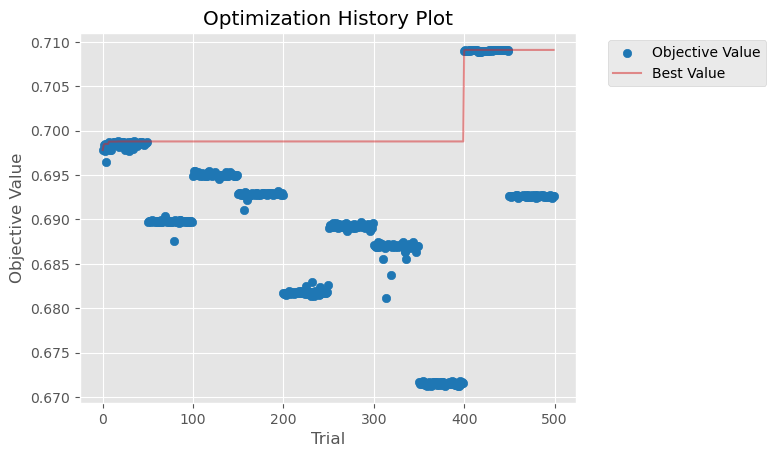

In [34]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_rf);

In [35]:
detailed_objective_rf_CV(study_rf.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.713690,0.052563
1,TP,17.000000,2.788867
2,TN,154.200000,1.751190
3,FP,3.400000,1.712698
4,FN,16.400000,3.405877
5,Accuracy,0.896335,0.021909
6,Precision,0.833371,0.084387
7,Sensitivity,0.510532,0.093030
8,Specificity,0.978450,0.010809
9,F1 score,0.629994,0.087130


In [36]:
mat_met_rf_test['ave'] = mat_met_rf_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_rf_test['std'] = mat_met_rf_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_rf_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.681830,0.697684,0.699576,0.707352,0.751351,0.708267,0.734025,0.763680,0.608475,0.715142,0.706738,0.042765
1,TP,30.000000,30.000000,32.000000,34.000000,35.000000,31.000000,31.000000,34.000000,37.000000,31.000000,32.500000,2.368778
2,TN,311.000000,308.000000,309.000000,314.000000,313.000000,308.000000,309.000000,311.000000,306.000000,310.000000,309.900000,2.424413
3,FP,5.000000,7.000000,5.000000,2.000000,3.000000,7.000000,7.000000,4.000000,8.000000,3.000000,5.100000,2.078995
4,FN,36.000000,37.000000,36.000000,32.000000,31.000000,36.000000,35.000000,33.000000,31.000000,38.000000,34.500000,2.549510
5,Accuracy,0.892670,0.884817,0.892670,0.910995,0.910995,0.887435,0.890052,0.903141,0.897906,0.892670,0.896335,0.009251
6,Precision,0.857143,0.810811,0.864865,0.944444,0.921053,0.815789,0.815789,0.894737,0.822222,0.911765,0.865862,0.049653
7,Sensitivity,0.454545,0.447761,0.470588,0.515152,0.530303,0.462687,0.469697,0.507463,0.544118,0.449275,0.485159,0.035732
8,Specificity,0.984200,0.977800,0.984100,0.993700,0.990500,0.977800,0.977800,0.987300,0.974500,0.990400,0.983810,0.006612
9,F1 score,0.594059,0.576923,0.609524,0.666667,0.673077,0.590476,0.596154,0.647619,0.654867,0.601942,0.621131,0.035536


In [37]:
#change to fit into these X values 

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = RandomForestRegressor(n_estimators = study_rf.best_params['n_estimators'],
                                            n_jobs=4, 
                                            random_state=5, 
                                            max_features = None,
                                            oob_score=True,
                                            max_samples=0.8,
                                          )
        optimizedCV_rf.fit(X_train,
                          y_train, 
                          
                  )
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_rf_cat = np.where(((y_pred_optimized_rf >= 2) | (y_pred_optimized_rf <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_run0.sort_values(by='y_test_idx0', inplace=True)
rf_run0.reset_index(inplace=True, drop=True)
rf_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_run1.sort_values(by='y_test_idx1', inplace=True)
rf_run1.reset_index(inplace=True, drop=True)
rf_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_run2.sort_values(by='y_test_idx2', inplace=True)
rf_run2.reset_index(inplace=True, drop=True)
rf_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_run3.sort_values(by='y_test_idx3', inplace=True)
rf_run3.reset_index(inplace=True, drop=True)
rf_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_run4.sort_values(by='y_test_idx4', inplace=True)
rf_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
rf_5preds = pd.concat([chembl_id, rf_run0, rf_run1, rf_run2, rf_run3, rf_run4], axis=1)
rf_5preds = rf_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds['y_pred_rf_ave'] = rf_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds['y_pred_rf_std'] = rf_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.713742,0.050191
1,Accuracy,0.898743,0.016063
2,Precision,0.862050,0.073262
3,Sensitivity,0.505121,0.085207
4,Specificity,0.982100,0.011558
5,F1 score,0.632220,0.072289
6,F1 score (weighted),0.887234,0.019614
7,F1 score (macro),0.786725,0.040307
8,Balanced Accuracy,0.743611,0.041953
9,MCC,0.608930,0.070889


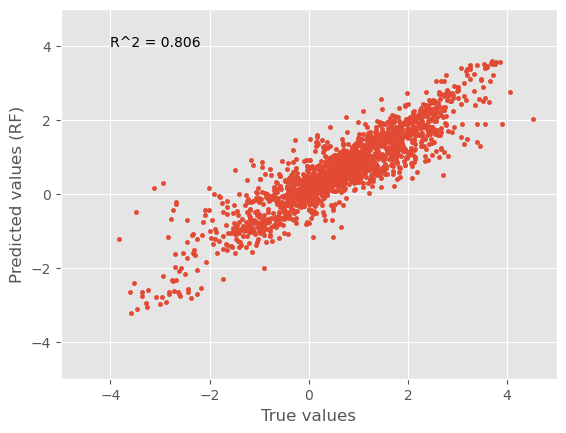

In [38]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (RF)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(rf_5preds['y_test0'], rf_5preds['y_pred_rf_ave'])), (-4, 4))
plt.show()

In [39]:
#cross valide using this optimized RF 
rf_baseline_CVscore = cross_val_score(rf_reg, X, Y, cv=10, scoring="r2")
#rf_opt_testSet_score = cross_val_score(optimized_rf, X, Y, cv=10, scoring="r2")
rf_opt_CVscore = cross_val_score(optimizedCV_rf, X, Y, cv=10, scoring="r2")
print("RF baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_baseline_CVscore), np.std(rf_baseline_CVscore, ddof=1)))
#print("RF optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (rf_opt_testSet_score.mean(), rf_opt_testSet_score.std()))
print("RF optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(rf_opt_CVscore), np.std(rf_opt_CVscore, ddof=1)))

RF baseline model r2_score 0.7093 with a standard deviation of 0.0544
RF optimized model r2_score 0.7114 with a standard deviation of 0.0584


In [40]:
joblib.dump(rf_reg, "OUTPUT/rf_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_rf, "OUTPUT/optimizedCV_rf_withSemiSel.joblib")

['OUTPUT/optimizedCV_rf_withSemiSel.joblib']

## LGBMRegressor

In [41]:
%%time


r2_scores = np.empty(10)
TP=np.empty(10)
TN = np.empty(10)
FP= np.empty(10)
FN= np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W=np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)

for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        
        lgbm_reg = lgbm.LGBMRegressor(
        objective="regression",
        random_state=1121218,
        #n_estimators=150,
        boosting_type ="gbdt",  # default histogram binning of LGBM,
        n_jobs=4,
        #min_child_samples = 15,
        subsample=0.8, # also called bagging_fraction
        subsample_freq=10,
     
           )


        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_reg.fit(
                    X_train,
                    y_train,
                    eval_set=eval_set,
                    eval_metric="rmse",
                    #early_stopping_rounds=150,
                    verbose=False,
                    )

        y_pred = lgbm_reg.predict(X_test) 
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met_lgbm = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
print(mat_met_lgbm)

                 Metric  Value (average)  Value (std)
0                    R2         0.713420     0.046195
1                    TP        17.200000     3.084009
2                    TN       153.200000     2.740641
3                    FP         4.400000     2.547330
4                    FN        16.200000     3.614784
5              Accuracy         0.892147     0.026946
6             Precision         0.800056     0.112857
7           Sensitivity         0.516414     0.101359
8           Specificity         0.972080     0.016210
9              F1 score         0.623993     0.096083
10  F1 score (weighted)         0.882115     0.030164
11     F1 score (macro)         0.780505     0.055718
12    Balanced Accuracy         0.744247     0.054514
13                  MCC         0.585270     0.108620
14                  NPV         0.904580     0.020428
15              ROC_AUC         0.744247     0.054514
CPU times: user 7.72 s, sys: 64 ms, total: 7.79 s
Wall time: 1.99 s


In [42]:
import optuna  

def objective_lgbm_CV(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        }
  
    
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=4,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [43]:
#this is basically inner set parameters
def detailed_objective_lgbm_cv(trial, X, Y, Y_class):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_bin": trial.suggest_int("max_bin", 150, 300),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"lambda_l1": trial.suggest_float("lambda_l1", 0, 0.001),
        #"lambda_l2": trial.suggest_float("lambda_l2", 1.0,100),
        "num_leaves": trial.suggest_int("num_leaves", 30, 750),
        #"min_child_samples": trial.suggest_int("min_child_samples", 15, 100),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.6,1),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        
    }
    
    
    
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M =np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        lgbm_model = lgbm.LGBMRegressor(objective="regression", 
                                            random_state=1121218, 
                                            boosting_type ="gbdt", 
                                            **param_grid, n_jobs=4,
                                            subsample=0.8, # also called bagging_fraction
                                            subsample_freq=10,
                                         )
    
        eval_set = [(X_train, y_train), (X_test, y_test)]
        lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        y_pred = lgbm_model.predict(X_test)
         # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    print(mat_met)

In [44]:
#Execute optuna and set hyperparameters
study_lgbm = optuna.create_study(direction='maximize', study_name="lgbmRegressor")
func_lgbm_0 = lambda trial: objective_lgbm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_lgbm.optimize(func_lgbm_0, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:32:00,379] A new study created in memory with name: lgbmRegressor
[I 2023-12-20 15:32:01,469] Trial 0 finished with value: 0.6732496870992574 and parameters: {'n_estimators': 106, 'learning_rate': 0.10712314672637993, 'max_depth': 8, 'max_bin': 156, 'num_leaves': 736}. Best is trial 0 with value: 0.6732496870992574.
[I 2023-12-20 15:32:02,074] Trial 1 finished with value: 0.6527622485348258 and parameters: {'n_estimators': 85, 'learning_rate': 0.19151573106555828, 'max_depth': 4, 'max_bin': 243, 'num_leaves': 651}. Best is trial 0 with value: 0.6732496870992574.
[I 2023-12-20 15:32:03,970] Trial 2 finished with value: 0.6532167099751477 and parameters: {'n_estimators': 869, 'learning_rate': 0.06083386933991966, 'max_depth': 3, 'max_bin': 182, 'num_leaves': 484}. Best is trial 0 with value: 0.6732496870992574.
[I 2023-12-20 15:32:05,755] Trial 3 finished with value: 0.6844494358416335 and parameters: {'n_estimators': 336, 'learning_rate': 0.18681192217273185, 'max_depth

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2023-12-20 15:32:29,876] Trial 11 finished with value: 0.694704784468181 and parameters: {'n_estimators': 657, 'learning_rate': 0.061710022160850336, 'max_depth': 10, 'max_bin': 209, 'num_leaves': 31}. Best is trial 9 with value: 0.7021717702064129.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2023-12-20 15:32:32,499] Trial 12 finished with value: 0.6962293837015472 and parameters: {'n_estimators': 708, 'learning_rate': 0.09032557491141055, 'max_depth': 10, 'max_bin': 221, 'num_leaves': 230}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:32:34,466] Trial 13 finished with value: 0.6899219850642416 and parameters: {'n_estimators': 530, 'learning_rate': 0.09287568031961188, 'max_depth': 10, 'max_bin': 275, 'num_leaves': 233}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:32:36,586] Trial 14 finished with value: 0.690647995142095 and parameters: {'n_estimators': 727, 'learning_rate': 0.10302694909617019, 'max_depth': 9, 'max_bin': 236, 'num_leaves': 259}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:32:38,319] Trial 15 finished with value: 0.6897724790887887 and parameters: {'n_estimators': 379, 'learning_rate': 0.12703045641350766, 'max_depth': 6, 'max_bin': 206, 'num_leaves': 154}. Best is trial 9 with value: 0.70217

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

[I 2023-12-20 15:34:10,035] Trial 44 finished with value: 0.6973043711359879 and parameters: {'n_estimators': 439, 'learning_rate': 0.02947161788436204, 'max_depth': 11, 'max_bin': 284, 'num_leaves': 31}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:34:16,005] Trial 45 finished with value: 0.6872421862217529 and parameters: {'n_estimators': 561, 'learning_rate': 0.014054193416701532, 'max_depth': 12, 'max_bin': 298, 'num_leaves': 120}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:34:19,719] Trial 46 finished with value: 0.6999181303849689 and parameters: {'n_estimators': 590, 'learning_rate': 0.04565188305960332, 'max_depth': 11, 'max_bin': 249, 'num_leaves': 179}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:34:24,318] Trial 47 finished with value: 0.6498048353062066 and parameters: {'n_estimators': 597, 'learning_rate': 0.009097858484573652, 'max_depth': 7, 'max_bin': 248, 'num_leaves': 168}. Best is trial 9 with value: 0.70

	Number of trials: 50.0
	Best value (r2_score): 0.7022
	Best params:
		n_estimators: 707
		learning_rate: 0.0490155009180803
		max_depth: 9
		max_bin: 293
		num_leaves: 51


In [45]:
optimized_lgbm_0 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
                                         
    
eval_set = [(X_testSet0, Y_testSet0)]
optimized_lgbm_0.fit(X_trainSet0,
                Y_trainSet0,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_0 = optimized_lgbm_0.predict(X_testSet0)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet0, y_pred_lgbm_0)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_0_cat = np.where(((y_pred_lgbm_0 >= 2) | (y_pred_lgbm_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_lgbm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_lgbm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_lgbm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_lgbm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_lgbm_0_cat)


mat_met_lgbm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    
    
print(mat_met_lgbm_test)



                 Metric        Set0
0                    R2    0.683653
1                    TP   28.000000
2                    TN  308.000000
3                    FP    8.000000
4                    FN   38.000000
5              Accuracy    0.879581
6             Precision    0.777778
7           Sensitivity    0.424242
8           Specificity    0.974700
9              F1 score    0.549020
10  F1 score (weighted)    0.864601
11     F1 score (macro)    0.739767
12    Balanced Accuracy    0.699463
13                  MCC    0.516201
14                  NPV    0.890200
15              ROC_AUC    0.699463


In [46]:
#Execute optuna and set hyperparameters

func_lgbm_1 = lambda trial: objective_lgbm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_lgbm.optimize(func_lgbm_1, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:34:37,696] Trial 50 finished with value: 0.685604749592542 and parameters: {'n_estimators': 646, 'learning_rate': 0.042679720171204284, 'max_depth': 12, 'max_bin': 269, 'num_leaves': 421}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:34:42,093] Trial 51 finished with value: 0.6864215500646342 and parameters: {'n_estimators': 533, 'learning_rate': 0.027553488964324274, 'max_depth': 12, 'max_bin': 263, 'num_leaves': 484}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:34:46,457] Trial 52 finished with value: 0.6865342621741682 and parameters: {'n_estimators': 515, 'learning_rate': 0.030264630881907072, 'max_depth': 11, 'max_bin': 259, 'num_leaves': 473}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:34:49,784] Trial 53 finished with value: 0.6899727624548124 and parameters: {'n_estimators': 413, 'learning_rate': 0.05616526628055647, 'max_depth': 12, 'max_bin': 280, 'num_leaves': 509}. Best is trial 9 with value: 0.

	Number of trials: 100.0
	Best value (r2_score): 0.7022
	Best params:
		n_estimators: 707
		learning_rate: 0.0490155009180803
		max_depth: 9
		max_bin: 293
		num_leaves: 51


In [47]:
optimized_lgbm_1 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_lgbm_1.fit(X_trainSet1,
                Y_trainSet1,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )

#predict        
y_pred_lgbm_1 = optimized_lgbm_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_lgbm_1)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_1_cat = np.where(((y_pred_lgbm_1 >= 2) | (y_pred_lgbm_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_lgbm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_lgbm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_lgbm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_lgbm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_lgbm_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set1'] =set1
print(mat_met_lgbm_test)


                 Metric        Set0        Set1
0                    R2    0.683653    0.738698
1                    TP   28.000000   35.000000
2                    TN  308.000000  308.000000
3                    FP    8.000000    7.000000
4                    FN   38.000000   32.000000
5              Accuracy    0.879581    0.897906
6             Precision    0.777778    0.833333
7           Sensitivity    0.424242    0.522388
8           Specificity    0.974700    0.977800
9              F1 score    0.549020    0.642202
10  F1 score (weighted)    0.864601    0.888146
11     F1 score (macro)    0.739767    0.791330
12    Balanced Accuracy    0.699463    0.750083
13                  MCC    0.516201    0.608055
14                  NPV    0.890200    0.905900
15              ROC_AUC    0.699463    0.750083


In [48]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_2 = lambda trial: objective_lgbm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_lgbm.optimize(func_lgbm_2, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:37:33,162] Trial 100 finished with value: 0.6973718171724748 and parameters: {'n_estimators': 723, 'learning_rate': 0.07096899535828852, 'max_depth': 10, 'max_bin': 236, 'num_leaves': 74}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:37:35,561] Trial 101 finished with value: 0.691896801442584 and parameters: {'n_estimators': 800, 'learning_rate': 0.07150028378570687, 'max_depth': 10, 'max_bin': 243, 'num_leaves': 71}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:37:38,288] Trial 102 finished with value: 0.695204783502729 and parameters: {'n_estimators': 747, 'learning_rate': 0.06252860021169972, 'max_depth': 11, 'max_bin': 225, 'num_leaves': 53}. Best is trial 9 with value: 0.7021717702064129.
[I 2023-12-20 15:37:41,074] Trial 103 finished with value: 0.6971660913889925 and parameters: {'n_estimators': 681, 'learning_rate': 0.07773268276219578, 'max_depth': 10, 'max_bin': 238, 'num_leaves': 103}. Best is trial 9 with value: 0.702

	Number of trials: 150.0
	Best value (r2_score): 0.7031
	Best params:
		n_estimators: 583
		learning_rate: 0.06575494649862133
		max_depth: 12
		max_bin: 276
		num_leaves: 677


In [49]:
optimized_lgbm_2 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet2, Y_testSet2)]
optimized_lgbm_2.fit(X_trainSet2,
                Y_trainSet2,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_2 = optimized_lgbm_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_lgbm_2)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet2 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_2_cat = np.where(((y_pred_lgbm_2 >= 2) | (y_pred_lgbm_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_lgbm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_lgbm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_lgbm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_lgbm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_lgbm_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set2'] = Set2
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.683653    0.738698    0.711055
1                    TP   28.000000   35.000000   38.000000
2                    TN  308.000000  308.000000  307.000000
3                    FP    8.000000    7.000000    7.000000
4                    FN   38.000000   32.000000   30.000000
5              Accuracy    0.879581    0.897906    0.903141
6             Precision    0.777778    0.833333    0.844444
7           Sensitivity    0.424242    0.522388    0.558824
8           Specificity    0.974700    0.977800    0.977700
9              F1 score    0.549020    0.642202    0.672566
10  F1 score (weighted)    0.864601    0.888146    0.894995
11     F1 score (macro)    0.739767    0.791330    0.807865
12    Balanced Accuracy    0.699463    0.750083    0.768265
13                  MCC    0.516201    0.608055    0.636638
14                  NPV    0.890200    0.905900    0.911000
15              ROC_AUC    0.699463    0

In [50]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_3 = lambda trial: objective_lgbm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_lgbm.optimize(func_lgbm_3, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:40:20,499] Trial 150 finished with value: 0.6710877982238073 and parameters: {'n_estimators': 488, 'learning_rate': 0.03986562213425826, 'max_depth': 7, 'max_bin': 282, 'num_leaves': 724}. Best is trial 139 with value: 0.7030588683541302.
[I 2023-12-20 15:40:23,416] Trial 151 finished with value: 0.6893197537143648 and parameters: {'n_estimators': 563, 'learning_rate': 0.0626219325922823, 'max_depth': 12, 'max_bin': 292, 'num_leaves': 674}. Best is trial 139 with value: 0.7030588683541302.
[I 2023-12-20 15:40:26,524] Trial 152 finished with value: 0.6896058244788856 and parameters: {'n_estimators': 517, 'learning_rate': 0.06788013542405076, 'max_depth': 12, 'max_bin': 273, 'num_leaves': 704}. Best is trial 139 with value: 0.7030588683541302.
[I 2023-12-20 15:40:29,766] Trial 153 finished with value: 0.682913486371748 and parameters: {'n_estimators': 586, 'learning_rate': 0.0435014466441565, 'max_depth': 12, 'max_bin': 297, 'num_leaves': 609}. Best is trial 139 with val

	Number of trials: 200.0
	Best value (r2_score): 0.7031
	Best params:
		n_estimators: 583
		learning_rate: 0.06575494649862133
		max_depth: 12
		max_bin: 276
		num_leaves: 677


In [51]:
optimized_lgbm_3 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet3, Y_testSet3)]
optimized_lgbm_3.fit(X_trainSet3,
                Y_trainSet3,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_3 = optimized_lgbm_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_lgbm_3)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet3 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_3_cat = np.where(((y_pred_lgbm_3 >= 2) | (y_pred_lgbm_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_lgbm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_lgbm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_lgbm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_lgbm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_lgbm_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set3'] = Set3
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.683653    0.738698    0.711055    0.746468
1                    TP   28.000000   35.000000   38.000000   33.000000
2                    TN  308.000000  308.000000  307.000000  311.000000
3                    FP    8.000000    7.000000    7.000000    5.000000
4                    FN   38.000000   32.000000   30.000000   33.000000
5              Accuracy    0.879581    0.897906    0.903141    0.900524
6             Precision    0.777778    0.833333    0.844444    0.868421
7           Sensitivity    0.424242    0.522388    0.558824    0.500000
8           Specificity    0.974700    0.977800    0.977700    0.984200
9              F1 score    0.549020    0.642202    0.672566    0.634615
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520
12    Balanced Accuracy    0.699463    0.750083    0.768265    0

In [52]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_4 = lambda trial: objective_lgbm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_lgbm.optimize(func_lgbm_4, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:43:13,075] Trial 200 finished with value: 0.6809139303481369 and parameters: {'n_estimators': 551, 'learning_rate': 0.03568282680605167, 'max_depth': 12, 'max_bin': 289, 'num_leaves': 669}. Best is trial 139 with value: 0.7030588683541302.
[I 2023-12-20 15:43:17,888] Trial 201 finished with value: 0.6811531120829432 and parameters: {'n_estimators': 512, 'learning_rate': 0.025306317078308292, 'max_depth': 12, 'max_bin': 260, 'num_leaves': 517}. Best is trial 139 with value: 0.7030588683541302.
[I 2023-12-20 15:43:23,474] Trial 202 finished with value: 0.6792238451197925 and parameters: {'n_estimators': 571, 'learning_rate': 0.01851870310199394, 'max_depth': 12, 'max_bin': 270, 'num_leaves': 684}. Best is trial 139 with value: 0.7030588683541302.
[I 2023-12-20 15:43:27,320] Trial 203 finished with value: 0.6807301660010665 and parameters: {'n_estimators': 540, 'learning_rate': 0.04076949708882506, 'max_depth': 12, 'max_bin': 262, 'num_leaves': 491}. Best is trial 139 wit

	Number of trials: 250.0
	Best value (r2_score): 0.7031
	Best params:
		n_estimators: 583
		learning_rate: 0.06575494649862133
		max_depth: 12
		max_bin: 276
		num_leaves: 677


In [53]:
optimized_lgbm_4 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet4, Y_testSet4)]
optimized_lgbm_4.fit(X_trainSet4,
                Y_trainSet4,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_4 = optimized_lgbm_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_lgbm_4)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet4 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_4_cat = np.where(((y_pred_lgbm_4 >= 2) | (y_pred_lgbm_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_lgbm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_lgbm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_lgbm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_lgbm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_lgbm_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set4'] = Set4
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683653    0.738698    0.711055    0.746468   
1                    TP   28.000000   35.000000   38.000000   33.000000   
2                    TN  308.000000  308.000000  307.000000  311.000000   
3                    FP    8.000000    7.000000    7.000000    5.000000   
4                    FN   38.000000   32.000000   30.000000   33.000000   
5              Accuracy    0.879581    0.897906    0.903141    0.900524   
6             Precision    0.777778    0.833333    0.844444    0.868421   
7           Sensitivity    0.424242    0.522388    0.558824    0.500000   
8           Specificity    0.974700    0.977800    0.977700    0.984200   
9              F1 score    0.549020    0.642202    0.672566    0.634615   
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243   
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520   
12    Balanced Accuracy  

In [54]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_5 = lambda trial: objective_lgbm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_lgbm.optimize(func_lgbm_5, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:45:59,502] Trial 250 finished with value: 0.711277234134928 and parameters: {'n_estimators': 583, 'learning_rate': 0.04607510723700235, 'max_depth': 12, 'max_bin': 270, 'num_leaves': 90}. Best is trial 250 with value: 0.711277234134928.
[I 2023-12-20 15:46:03,731] Trial 251 finished with value: 0.715391192209114 and parameters: {'n_estimators': 583, 'learning_rate': 0.043847252608175395, 'max_depth': 12, 'max_bin': 274, 'num_leaves': 83}. Best is trial 251 with value: 0.715391192209114.
[I 2023-12-20 15:46:06,807] Trial 252 finished with value: 0.6978733196732303 and parameters: {'n_estimators': 580, 'learning_rate': 0.04511876593973528, 'max_depth': 8, 'max_bin': 272, 'num_leaves': 87}. Best is trial 251 with value: 0.715391192209114.
[I 2023-12-20 15:46:10,901] Trial 253 finished with value: 0.7093509878945821 and parameters: {'n_estimators': 596, 'learning_rate': 0.04290236703664538, 'max_depth': 12, 'max_bin': 275, 'num_leaves': 80}. Best is trial 251 with value: 0

	Number of trials: 300.0
	Best value (r2_score): 0.7160
	Best params:
		n_estimators: 608
		learning_rate: 0.038359808960956705
		max_depth: 12
		max_bin: 276
		num_leaves: 74


In [55]:
optimized_lgbm_5 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet5, Y_testSet5)]
optimized_lgbm_5.fit(X_trainSet5,
                Y_trainSet5,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_5 = optimized_lgbm_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_lgbm_5)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet5 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_5_cat = np.where(((y_pred_lgbm_5 >= 2) | (y_pred_lgbm_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_lgbm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_lgbm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_lgbm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_lgbm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_lgbm_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set5'] = Set5
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683653    0.738698    0.711055    0.746468   
1                    TP   28.000000   35.000000   38.000000   33.000000   
2                    TN  308.000000  308.000000  307.000000  311.000000   
3                    FP    8.000000    7.000000    7.000000    5.000000   
4                    FN   38.000000   32.000000   30.000000   33.000000   
5              Accuracy    0.879581    0.897906    0.903141    0.900524   
6             Precision    0.777778    0.833333    0.844444    0.868421   
7           Sensitivity    0.424242    0.522388    0.558824    0.500000   
8           Specificity    0.974700    0.977800    0.977700    0.984200   
9              F1 score    0.549020    0.642202    0.672566    0.634615   
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243   
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520   
12    Balanced Accuracy  

In [56]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_6 = lambda trial: objective_lgbm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_lgbm.optimize(func_lgbm_6, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.6f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:49:38,939] Trial 300 finished with value: 0.7028444528054899 and parameters: {'n_estimators': 643, 'learning_rate': 0.040907451834723524, 'max_depth': 12, 'max_bin': 288, 'num_leaves': 185}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:49:43,396] Trial 301 finished with value: 0.7031896444694234 and parameters: {'n_estimators': 635, 'learning_rate': 0.04041289727750784, 'max_depth': 12, 'max_bin': 291, 'num_leaves': 164}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:49:48,055] Trial 302 finished with value: 0.6996923702639672 and parameters: {'n_estimators': 646, 'learning_rate': 0.0303056492888822, 'max_depth': 11, 'max_bin': 286, 'num_leaves': 153}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:49:52,092] Trial 303 finished with value: 0.6976180325739086 and parameters: {'n_estimators': 628, 'learning_rate': 0.04107609571309203, 'max_depth': 12, 'max_bin': 289, 'num_leaves': 144}. Best is trial 267 with

	Number of trials: 350.0
	Best value (r2_score): 0.716046
	Best params:
		n_estimators: 608
		learning_rate: 0.038359808960956705
		max_depth: 12
		max_bin: 276
		num_leaves: 74


In [57]:
optimized_lgbm_6 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet6, Y_testSet6)]
optimized_lgbm_6.fit(X_trainSet6,
                Y_trainSet6,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_6 = optimized_lgbm_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_lgbm_6)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet6 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_6_cat = np.where(((y_pred_lgbm_6 >= 2) | (y_pred_lgbm_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_lgbm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_lgbm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_lgbm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_lgbm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_lgbm_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set6'] = Set6
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683653    0.738698    0.711055    0.746468   
1                    TP   28.000000   35.000000   38.000000   33.000000   
2                    TN  308.000000  308.000000  307.000000  311.000000   
3                    FP    8.000000    7.000000    7.000000    5.000000   
4                    FN   38.000000   32.000000   30.000000   33.000000   
5              Accuracy    0.879581    0.897906    0.903141    0.900524   
6             Precision    0.777778    0.833333    0.844444    0.868421   
7           Sensitivity    0.424242    0.522388    0.558824    0.500000   
8           Specificity    0.974700    0.977800    0.977700    0.984200   
9              F1 score    0.549020    0.642202    0.672566    0.634615   
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243   
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520   
12    Balanced Accuracy  

In [58]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_7 = lambda trial: objective_lgbm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_lgbm.optimize(func_lgbm_7, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.7f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:53:32,909] Trial 350 finished with value: 0.6761522906151789 and parameters: {'n_estimators': 626, 'learning_rate': 0.03838201855962258, 'max_depth': 11, 'max_bin': 276, 'num_leaves': 108}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:53:35,178] Trial 351 finished with value: 0.6751593060454446 and parameters: {'n_estimators': 597, 'learning_rate': 0.09867238043596463, 'max_depth': 12, 'max_bin': 281, 'num_leaves': 221}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:53:39,413] Trial 352 finished with value: 0.6792758468578826 and parameters: {'n_estimators': 607, 'learning_rate': 0.03651393741529004, 'max_depth': 12, 'max_bin': 151, 'num_leaves': 136}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:53:42,879] Trial 353 finished with value: 0.6735631440017059 and parameters: {'n_estimators': 634, 'learning_rate': 0.04226655648222106, 'max_depth': 12, 'max_bin': 289, 'num_leaves': 99}. Best is trial 267 with 

	Number of trials: 400.0
	Best value (r2_score): 0.7160462
	Best params:
		n_estimators: 608
		learning_rate: 0.038359808960956705
		max_depth: 12
		max_bin: 276
		num_leaves: 74


In [59]:
optimized_lgbm_7 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet7, Y_testSet7)]
optimized_lgbm_7.fit(X_trainSet7,
                Y_trainSet7,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_7 = optimized_lgbm_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_lgbm_7)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet7 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_7_cat = np.where(((y_pred_lgbm_7 >= 2) | (y_pred_lgbm_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_lgbm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_lgbm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_lgbm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_lgbm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_lgbm_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set7'] = Set7
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683653    0.738698    0.711055    0.746468   
1                    TP   28.000000   35.000000   38.000000   33.000000   
2                    TN  308.000000  308.000000  307.000000  311.000000   
3                    FP    8.000000    7.000000    7.000000    5.000000   
4                    FN   38.000000   32.000000   30.000000   33.000000   
5              Accuracy    0.879581    0.897906    0.903141    0.900524   
6             Precision    0.777778    0.833333    0.844444    0.868421   
7           Sensitivity    0.424242    0.522388    0.558824    0.500000   
8           Specificity    0.974700    0.977800    0.977700    0.984200   
9              F1 score    0.549020    0.642202    0.672566    0.634615   
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243   
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520   
12    Balanced Accuracy  

In [60]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_8 = lambda trial: objective_lgbm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_lgbm.optimize(func_lgbm_8, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.8f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:56:48,075] Trial 400 finished with value: 0.691127025484482 and parameters: {'n_estimators': 605, 'learning_rate': 0.011648841500299836, 'max_depth': 12, 'max_bin': 198, 'num_leaves': 142}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:56:53,048] Trial 401 finished with value: 0.7009855686066209 and parameters: {'n_estimators': 639, 'learning_rate': 0.03160361746274281, 'max_depth': 12, 'max_bin': 272, 'num_leaves': 88}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:56:56,978] Trial 402 finished with value: 0.7071730202955304 and parameters: {'n_estimators': 565, 'learning_rate': 0.047069917274126905, 'max_depth': 12, 'max_bin': 281, 'num_leaves': 60}. Best is trial 267 with value: 0.7160461960640584.
[I 2023-12-20 15:57:03,451] Trial 403 finished with value: 0.7004682347900502 and parameters: {'n_estimators': 616, 'learning_rate': 0.017475701022045993, 'max_depth': 12, 'max_bin': 207, 'num_leaves': 117}. Best is trial 267 with

	Number of trials: 450.0
	Best value (r2_score): 0.71920057
	Best params:
		n_estimators: 763
		learning_rate: 0.10590324427906232
		max_depth: 11
		max_bin: 295
		num_leaves: 404


In [61]:
optimized_lgbm_8 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet8, Y_testSet8)]
optimized_lgbm_8.fit(X_trainSet8,
                Y_trainSet8,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_8 = optimized_lgbm_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_lgbm_8)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet8 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_8_cat = np.where(((y_pred_lgbm_8 >= 2) | (y_pred_lgbm_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_lgbm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_lgbm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_lgbm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_lgbm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_lgbm_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set8'] = Set8
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683653    0.738698    0.711055    0.746468   
1                    TP   28.000000   35.000000   38.000000   33.000000   
2                    TN  308.000000  308.000000  307.000000  311.000000   
3                    FP    8.000000    7.000000    7.000000    5.000000   
4                    FN   38.000000   32.000000   30.000000   33.000000   
5              Accuracy    0.879581    0.897906    0.903141    0.900524   
6             Precision    0.777778    0.833333    0.844444    0.868421   
7           Sensitivity    0.424242    0.522388    0.558824    0.500000   
8           Specificity    0.974700    0.977800    0.977700    0.984200   
9              F1 score    0.549020    0.642202    0.672566    0.634615   
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243   
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520   
12    Balanced Accuracy  

In [62]:
#Execute optuna and set hyperparameters
#study_lgbm_1 = optuna.create_study(direction='maximize', study_name="lgbmRegressor_1")
func_lgbm_9 = lambda trial: objective_lgbm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_lgbm.optimize(func_lgbm_9, n_trials=50)  
print(f"\tNumber of trials: {len(study_lgbm.trials):.1f}")
print(f"\tBest value (r2_score): {study_lgbm.best_value:.9f}")
print(f"\tBest params:")

for key, value in study_lgbm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 15:59:16,964] Trial 450 finished with value: 0.7004793524816819 and parameters: {'n_estimators': 828, 'learning_rate': 0.1122113303076513, 'max_depth': 11, 'max_bin': 296, 'num_leaves': 411}. Best is trial 448 with value: 0.7192005666366479.
[I 2023-12-20 15:59:19,412] Trial 451 finished with value: 0.7020914256242299 and parameters: {'n_estimators': 776, 'learning_rate': 0.11406507532598462, 'max_depth': 11, 'max_bin': 294, 'num_leaves': 323}. Best is trial 448 with value: 0.7192005666366479.
[I 2023-12-20 15:59:21,973] Trial 452 finished with value: 0.7060389733583661 and parameters: {'n_estimators': 759, 'learning_rate': 0.10585163276436171, 'max_depth': 11, 'max_bin': 297, 'num_leaves': 300}. Best is trial 448 with value: 0.7192005666366479.
[I 2023-12-20 15:59:24,769] Trial 453 finished with value: 0.707498701261156 and parameters: {'n_estimators': 790, 'learning_rate': 0.10246944084482155, 'max_depth': 11, 'max_bin': 300, 'num_leaves': 394}. Best is trial 448 with v

	Number of trials: 500.0
	Best value (r2_score): 0.719200567
	Best params:
		n_estimators: 763
		learning_rate: 0.10590324427906232
		max_depth: 11
		max_bin: 295
		num_leaves: 404


In [63]:
optimized_lgbm_9 = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


#learn
eval_set = [(X_testSet9, Y_testSet9)]
optimized_lgbm_9.fit(X_trainSet9,
                Y_trainSet9,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
        

#predict        
y_pred_lgbm_9 = optimized_lgbm_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_lgbm_9)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet9 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_lgbm_9_cat = np.where(((y_pred_lgbm_9 >= 2) | (y_pred_lgbm_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_lgbm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_lgbm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_lgbm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_lgbm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_lgbm_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_lgbm_test['Set9'] = Set9
print(mat_met_lgbm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.683653    0.738698    0.711055    0.746468   
1                    TP   28.000000   35.000000   38.000000   33.000000   
2                    TN  308.000000  308.000000  307.000000  311.000000   
3                    FP    8.000000    7.000000    7.000000    5.000000   
4                    FN   38.000000   32.000000   30.000000   33.000000   
5              Accuracy    0.879581    0.897906    0.903141    0.900524   
6             Precision    0.777778    0.833333    0.844444    0.868421   
7           Sensitivity    0.424242    0.522388    0.558824    0.500000   
8           Specificity    0.974700    0.977800    0.977700    0.984200   
9              F1 score    0.549020    0.642202    0.672566    0.634615   
10  F1 score (weighted)    0.864601    0.888146    0.894995    0.889243   
11     F1 score (macro)    0.739767    0.791330    0.807865    0.788520   
12    Balanced Accuracy  

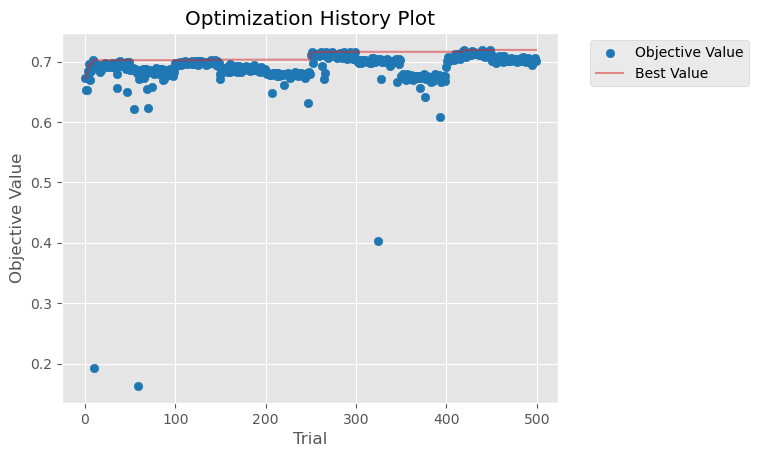

In [64]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_lgbm);

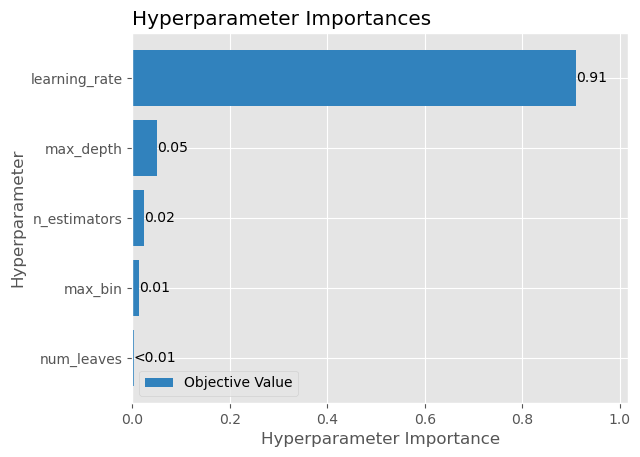

In [65]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study_lgbm);

In [66]:
detailed_objective_lgbm_cv(study_lgbm.best_trial, X, Y, Y_class)

                 Metric  Value (average)  Value (std)
0                    R2         0.726045     0.042989
1                    TP        18.200000     3.011091
2                    TN       153.500000     2.321398
3                    FP         4.100000     1.969207
4                    FN        15.200000     3.190263
5              Accuracy         0.898953     0.021238
6             Precision         0.817940     0.081185
7           Sensitivity         0.545369     0.092737
8           Specificity         0.973980     0.012554
9              F1 score         0.651014     0.083058
10  F1 score (weighted)         0.890139     0.024625
11     F1 score (macro)         0.795945     0.047342
12    Balanced Accuracy         0.759671     0.047892
13                  MCC         0.613623     0.088125
14                  NPV         0.910120     0.017535
15              ROC_AUC         0.759671     0.047892


In [67]:
mat_met_lgbm_test['ave'] = mat_met_lgbm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_lgbm_test['std'] = mat_met_lgbm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_lgbm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.683653,0.738698,0.711055,0.746468,0.786615,0.710276,0.772399,0.781568,0.623498,0.724391,0.727862,0.049703
1,TP,28.000000,35.000000,38.000000,33.000000,36.000000,34.000000,33.000000,37.000000,35.000000,37.000000,34.600000,2.875181
2,TN,308.000000,308.000000,307.000000,311.000000,308.000000,304.000000,307.000000,307.000000,306.000000,307.000000,307.300000,1.766981
3,FP,8.000000,7.000000,7.000000,5.000000,8.000000,11.000000,9.000000,8.000000,8.000000,6.000000,7.700000,1.636392
4,FN,38.000000,32.000000,30.000000,33.000000,30.000000,33.000000,33.000000,30.000000,33.000000,32.000000,32.400000,2.366432
5,Accuracy,0.879581,0.897906,0.903141,0.900524,0.900524,0.884817,0.890052,0.900524,0.892670,0.900524,0.895026,0.007945
6,Precision,0.777778,0.833333,0.844444,0.868421,0.818182,0.755556,0.785714,0.822222,0.813953,0.860465,0.818007,0.036322
7,Sensitivity,0.424242,0.522388,0.558824,0.500000,0.545455,0.507463,0.500000,0.552239,0.514706,0.536232,0.516155,0.038688
8,Specificity,0.974700,0.977800,0.977700,0.984200,0.974700,0.965100,0.971500,0.974600,0.974500,0.980800,0.975560,0.005176
9,F1 score,0.549020,0.642202,0.672566,0.634615,0.654545,0.607143,0.611111,0.660714,0.630631,0.660714,0.632326,0.036293


In [68]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_lgbm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = lgbm.LGBMRegressor(objective="regression", 
                                      random_state=1121218, 
                                      boosting_type ="gbdt", 
                                      subsample=0.8, # also called bagging_fraction
                                      subsample_freq=10,
                                      n_estimators=study_lgbm.best_params['n_estimators'],
                                      learning_rate=study_lgbm.best_params['learning_rate'],
                                      max_depth = study_lgbm.best_params['max_depth'],
                                      max_bin=study_lgbm.best_params['max_bin'],
                                      #lambda_l1 = study_lgbm.best_params['lambda_l1'],
                                      #lambda_l2= study_lgbm.best_params['lambda_l2'],
                                      num_leaves=study_lgbm.best_params['num_leaves'],
                                      #min_child_samples = study_lgbm.best_params['min_child_samples'],
                                      #bagging_fraction = study_lgbm.best_params['bagging_fraction'],
                                      #bagging_freq = study_lgbm.best_params['bagging_freq'],
                                        
                                        )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_lgbm.fit(X_train,
                y_train,
                eval_set=eval_set,
                eval_metric="rmse",     
                early_stopping_rounds=50,
                verbose = False,
                )
                          
                  
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where(((y_pred_optimized_lgbm >= 2) | (y_pred_optimized_lgbm <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_run0.reset_index(inplace=True, drop=True)
lgbm_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_run1.reset_index(inplace=True, drop=True)
lgbm_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_run2.reset_index(inplace=True, drop=True)
lgbm_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_run3.reset_index(inplace=True, drop=True)
lgbm_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
lgbm_5preds = pd.concat([chembl_id, lgbm_run0, lgbm_run1, lgbm_run2, lgbm_run3, lgbm_run4], axis=1)
lgbm_5preds = lgbm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds['y_pred_lgbm_ave'] = lgbm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds['y_pred_lgbm_std'] = lgbm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_lgbm

,Metric,Value (average),Value (std)
0,R2,0.723771,0.044310
1,Accuracy,0.900000,0.018052
2,Precision,0.839621,0.084283
3,Sensitivity,0.535663,0.091647
4,Specificity,0.977162,0.014108
5,F1 score,0.648532,0.075382
6,F1 score (weighted),0.890421,0.021129
7,F1 score (macro),0.795084,0.042415
8,Balanced Accuracy,0.756408,0.045183
9,MCC,0.617399,0.077112


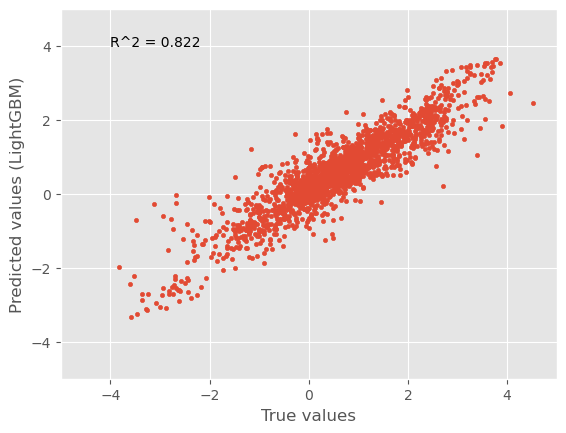

In [69]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(lgbm_5preds['y_test0'], lgbm_5preds['y_pred_lgbm_ave'])), (-4, 4))
plt.show()

In [70]:
#cross valide using this optimized LightGBM 
fit_params={'early_stopping_rounds': 50, 
        'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
            'verbose':False,
           }
#cross valide using this optimized LightGBM 
lgbm_baseline_CVscore = cross_val_score(lgbm_reg, X, Y, cv=10, scoring="r2")
#r2_cv_lgbm_opt_testSet = cross_val_score(optimized_lgbm, X, Y, cv=10, scoring="r2")
r2_cv_lgbm_opt = cross_val_score(optimizedCV_lgbm, X, Y, cv=10, scoring="r2", fit_params=fit_params)
print("LightGBM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(lgbm_baseline_CVscore), np.std(lgbm_baseline_CVscore, ddof=1)))
#print("LightGBM optimized model (tested on Y_te)r2_score %0.4f with a standard deviation of %0.4f" % (r2_cv_lgbm_opt_testSet.mean(), r2_cv_lgbm_opt_testSet.std()))
print("LightGBM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(r2_cv_lgbm_opt), np.std(r2_cv_lgbm_opt, ddof=1)))

LightGBM baseline model r2_score 0.7184 with a standard deviation of 0.0522
LightGBM optimized model r2_score 0.7271 with a standard deviation of 0.0540


In [71]:
joblib.dump(lgbm_reg, "OUTPUT/lgbm_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_lgbm, "OUTPUT/optimizedCV_lgbm_withSemiSel.joblib") 

['OUTPUT/optimizedCV_lgbm_withSemiSel.joblib']

## XGBoost

In [72]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=1121218,
    #n_estimators=10000,  
    tree_method="hist",  # enable histogram binning in XGB
    subsample=0.8, 
    )
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_reg.fit(X_train,
                y_train,
    
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=False,  # Disable logs
               )

    y_pred = xgb_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.3
    y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
    y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores),np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.712599     0.056262
1                    TP        17.500000     4.006938
2                    TN       153.800000     2.201010
3                    FP         3.800000     1.988858
4                    FN        15.900000     4.357624
5              Accuracy         0.896859     0.029208
6             Precision         0.817065     0.097054
7           Sensitivity         0.525122     0.125555
8           Specificity         0.975890     0.012606
9              F1 score         0.635180     0.117576
10  F1 score (weighted)         0.886478     0.034547
11     F1 score (macro)         0.787539     0.066974
12    Balanced Accuracy         0.750505     0.066205
13                  MCC         0.600572     0.123774
14                  NPV         0.906680     0.024038
15              ROC_AUC         0.750505     0.066205
CPU times: user 52.8 s, sys: 76.1 ms, total: 52.9 s
Wall time: 1.77 s


In [73]:
def objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    cv_scores=np.empty(10)
    #y_comb=pd.DataFrame()
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=4, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
    
        y_pred = xgb_model.predict(X_test)
        cv_scores[idx] = r2_score(y_test, y_pred)
            
    return np.mean(cv_scores)

In [74]:
def detailed_objective_xgb_CV(trial, X, Y, Y_class):
    param_grid = {
        
        "n_estimators": trial.suggest_int("n_estimators", 50, 900),
        "eta": trial.suggest_float("eta", 1e-6, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 5, 12),  
        "alpha": trial.suggest_float("alpha", 0, 1, step=1e-04),
        "lambda": trial.suggest_float("lambda", 1,40),
        #"alpha": trial.suggest_float("alpha", 0, 1.0),
        #"lambda": trial.suggest_float("lambda", 1e-8, 40.0),
        "max_bin": trial.suggest_int("max_bin", 250, 500),
    }
    
    
    r2_scores = np.empty(10)
    TP=np.empty(10)
    TN = np.empty(10)
    FP= np.empty(10)
    FN= np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W=np.empty(10)
    f1_scores_M=np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)
    
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=1121218, booster ="gbtree", tree_method='hist',
                                  **param_grid,  n_jobs=4, subsample=0.8, )
    
        eval_set = [(X_test, y_test)]
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=eval_set,
            eval_metric="rmse",    
            early_stopping_rounds=50,
            verbose=False)
        
        y_pred = xgb_model.predict(X_test)
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # convert to categorical values
        y_test_cat = np.where( ((y_test>=2) | (y_test<= -2.0)), 1, 0) 
        y_pred_cat = np.where(((y_pred>=2) | (y_pred<= -2.0)), 1, 0)
       
           
        #calculate parameters
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)      
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)

    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })   
    
    return (mat_met)   

In [75]:
#Execute optuna and set hyperparameters
study_xgb = optuna.create_study(direction='maximize', study_name="XGBRegressor")
func_xgb_0 = lambda trial: objective_xgb_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_xgb.optimize(func_xgb_0, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 16:02:10,495] A new study created in memory with name: XGBRegressor
[I 2023-12-20 16:02:19,074] Trial 0 finished with value: 0.7095943113467135 and parameters: {'n_estimators': 754, 'eta': 0.04716605607040766, 'max_depth': 5, 'alpha': 0.031900000000000005, 'lambda': 23.652460849810737, 'max_bin': 252}. Best is trial 0 with value: 0.7095943113467135.
[I 2023-12-20 16:02:35,342] Trial 1 finished with value: 0.7158830095833487 and parameters: {'n_estimators': 884, 'eta': 0.02093699152435154, 'max_depth': 7, 'alpha': 0.0257, 'lambda': 24.19034538160919, 'max_bin': 276}. Best is trial 1 with value: 0.7158830095833487.
[I 2023-12-20 16:02:45,609] Trial 2 finished with value: 0.7185577498660882 and parameters: {'n_estimators': 595, 'eta': 0.06652920859457241, 'max_depth': 7, 'alpha': 0.298, 'lambda': 34.39521004648528, 'max_bin': 322}. Best is trial 2 with value: 0.7185577498660882.
[I 2023-12-20 16:02:51,890] Trial 3 finished with value: 0.7105203189390983 and parameters: {'n_e

	Number of trials: 50.0
	Best value (r2_score): 0.7297
	Best params:
		n_estimators: 886
		eta: 0.039303415262369676
		max_depth: 12
		alpha: 0.3921
		lambda: 11.481057191444393
		max_bin: 312


In [76]:
#Create an instance with tuned hyperparameters

optimized_xgb_0 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    #learn
eval_set = [(X_testSet0, Y_testSet0)]

optimized_xgb_0.fit(X_trainSet0,Y_trainSet0, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

    # r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_xgb_0 = optimized_xgb_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_xgb_0)
# now convert the resuls to binary with cutoff 6.3
Y_testSet0_cat = np.where(((Y_testSet0>=2) | (Y_testSet0<=-2)), 1, 0) 
y_pred_xgb_0_cat = np.where(((y_pred_xgb_0 >= 2) | (y_pred_xgb_0 <= -2)), 1, 0)
    #calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_xgb_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_xgb_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_xgb_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_xgb_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_xgb_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_xgb_0_cat)
    

mat_met_xgb_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_xgb_test)


                 Metric        Set0
0                    R2    0.703752
1                    TP   34.000000
2                    TN  304.000000
3                    FP   12.000000
4                    FN   32.000000
5              Accuracy    0.884817
6             Precision    0.739130
7           Sensitivity    0.515152
8           Specificity    0.962000
9              F1 score    0.607143
10  F1 score (weighted)    0.876299
11     F1 score (macro)    0.769829
12    Balanced Accuracy    0.738588
13                  MCC    0.554302
14                  NPV    0.904800
15              ROC_AUC    0.738588


In [77]:
#Execute optuna and set hyperparameters

func_xgb_1 = lambda trial: objective_xgb_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_xgb.optimize(func_xgb_1, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 16:11:48,858] Trial 50 finished with value: 0.7182347595523727 and parameters: {'n_estimators': 695, 'eta': 0.03843199838546809, 'max_depth': 11, 'alpha': 0.6559, 'lambda': 15.008664215793877, 'max_bin': 428}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:11:58,114] Trial 51 finished with value: 0.7140854767415538 and parameters: {'n_estimators': 615, 'eta': 0.06262288417498246, 'max_depth': 10, 'alpha': 0.4974, 'lambda': 16.473160235975993, 'max_bin': 339}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:12:05,961] Trial 52 finished with value: 0.719252244033832 and parameters: {'n_estimators': 588, 'eta': 0.06477569225770645, 'max_depth': 9, 'alpha': 0.46480000000000005, 'lambda': 15.343920759478047, 'max_bin': 331}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:12:15,274] Trial 53 finished with value: 0.7159567558851819 and parameters: {'n_estimators': 467, 'eta': 0.05962763991982807, 'max_depth': 10, 'alpha': 0

	Number of trials: 100.0
	Best value (r2_score): 0.7297
	Best params:
		n_estimators: 886
		eta: 0.039303415262369676
		max_depth: 12
		alpha: 0.3921
		lambda: 11.481057191444393
		max_bin: 312


In [78]:
optimized_xgb_1 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet1, Y_testSet1)]
optimized_xgb_1.fit(X_trainSet1,Y_trainSet1, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_1 = optimized_xgb_1.predict(X_testSet1)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet1, y_pred_xgb_1)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet1 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_1_cat = np.where(((y_pred_xgb_1 >= 2) | (y_pred_xgb_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_xgb_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_xgb_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_xgb_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_xgb_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_xgb_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_xgb_1_cat)


set1 = pd.DataFrame({ 'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set1'] =set1
print(mat_met_xgb_test)


                 Metric        Set0        Set1
0                    R2    0.703752    0.746467
1                    TP   34.000000   37.000000
2                    TN  304.000000  305.000000
3                    FP   12.000000   10.000000
4                    FN   32.000000   30.000000
5              Accuracy    0.884817    0.895288
6             Precision    0.739130    0.787234
7           Sensitivity    0.515152    0.552239
8           Specificity    0.962000    0.968300
9              F1 score    0.607143    0.649123
10  F1 score (weighted)    0.876299    0.887714
11     F1 score (macro)    0.769829    0.793792
12    Balanced Accuracy    0.738588    0.760246
13                  MCC    0.554302    0.602610
14                  NPV    0.904800    0.910400
15              ROC_AUC    0.738588    0.760246


In [79]:
#Execute optuna and set hyperparameters
func_xgb_2 = lambda trial: objective_xgb_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_xgb.optimize(func_xgb_2, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 16:21:04,612] Trial 100 finished with value: 0.7201927137680045 and parameters: {'n_estimators': 879, 'eta': 0.036021897574469434, 'max_depth': 12, 'alpha': 0.4409, 'lambda': 17.14508514693859, 'max_bin': 340}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:21:21,269] Trial 101 finished with value: 0.721287874369007 and parameters: {'n_estimators': 860, 'eta': 0.04169670036789745, 'max_depth': 11, 'alpha': 0.32580000000000003, 'lambda': 20.76243743107996, 'max_bin': 267}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:21:23,587] Trial 102 finished with value: 0.6543810554656387 and parameters: {'n_estimators': 71, 'eta': 0.043685723401178274, 'max_depth': 10, 'alpha': 0.38520000000000004, 'lambda': 13.927028972722182, 'max_bin': 271}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:21:38,488] Trial 103 finished with value: 0.7174339014400204 and parameters: {'n_estimators': 838, 'eta': 0.04581797059429766, 'max_depth

	Number of trials: 150.0
	Best value (r2_score): 0.7297
	Best params:
		n_estimators: 886
		eta: 0.039303415262369676
		max_depth: 12
		alpha: 0.3921
		lambda: 11.481057191444393
		max_bin: 312


In [80]:
optimized_xgb_2 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet2, Y_testSet2)]
optimized_xgb_2.fit(X_trainSet2,Y_trainSet2, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_2 = optimized_xgb_2.predict(X_testSet2)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet2, y_pred_xgb_2)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet2 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_2_cat = np.where(((y_pred_xgb_2 >= 2) | (y_pred_xgb_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_xgb_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_xgb_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_xgb_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_xgb_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_xgb_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_xgb_2_cat)


Set2 = pd.DataFrame({ 'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set2'] =Set2
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.703752    0.746467    0.736627
1                    TP   34.000000   37.000000   37.000000
2                    TN  304.000000  305.000000  308.000000
3                    FP   12.000000   10.000000    6.000000
4                    FN   32.000000   30.000000   31.000000
5              Accuracy    0.884817    0.895288    0.903141
6             Precision    0.739130    0.787234    0.860465
7           Sensitivity    0.515152    0.552239    0.544118
8           Specificity    0.962000    0.968300    0.980900
9              F1 score    0.607143    0.649123    0.666667
10  F1 score (weighted)    0.876299    0.887714    0.894088
11     F1 score (macro)    0.769829    0.793792    0.805003
12    Balanced Accuracy    0.738588    0.760246    0.762505
13                  MCC    0.554302    0.602610    0.635407
14                  NPV    0.904800    0.910400    0.908600
15              ROC_AUC    0.738588    0

In [81]:
#Execute optuna and set hyperparameters
func_xgb_3 = lambda trial: objective_xgb_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_xgb.optimize(func_xgb_3, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 16:31:00,974] Trial 150 finished with value: 0.7269194639345007 and parameters: {'n_estimators': 611, 'eta': 0.05853101154193337, 'max_depth': 11, 'alpha': 0.501, 'lambda': 7.487954049074521, 'max_bin': 290}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:31:11,327] Trial 151 finished with value: 0.7192096246618392 and parameters: {'n_estimators': 576, 'eta': 0.059066058050076, 'max_depth': 11, 'alpha': 0.509, 'lambda': 9.195321189053578, 'max_bin': 288}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:31:20,152] Trial 152 finished with value: 0.7242539466756162 and parameters: {'n_estimators': 619, 'eta': 0.06443833797785972, 'max_depth': 11, 'alpha': 0.4928, 'lambda': 5.5962276423353705, 'max_bin': 324}. Best is trial 21 with value: 0.7296504000963024.
[I 2023-12-20 16:31:30,805] Trial 153 finished with value: 0.7229010696054321 and parameters: {'n_estimators': 519, 'eta': 0.05636390475866544, 'max_depth': 11, 'alpha': 0.4461, 'lambd

	Number of trials: 200.0
	Best value (r2_score): 0.7313
	Best params:
		n_estimators: 686
		eta: 0.043404992941413346
		max_depth: 11
		alpha: 0.08270000000000001
		lambda: 17.62920128007734
		max_bin: 373


In [82]:
optimized_xgb_3 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet3, Y_testSet3)]
optimized_xgb_3.fit(X_trainSet3,Y_trainSet3, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_3 = optimized_xgb_3.predict(X_testSet3)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet3, y_pred_xgb_3)
# now convert the resuls to binary with cutoff 6.3
#Y_trainSet3 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_3_cat = np.where(((y_pred_xgb_3 >= 2) | (y_pred_xgb_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_xgb_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_xgb_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_xgb_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_xgb_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_xgb_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_xgb_3_cat)


Set3 = pd.DataFrame({ 'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set3'] =Set3
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.703752    0.746467    0.736627    0.749621
1                    TP   34.000000   37.000000   37.000000   34.000000
2                    TN  304.000000  305.000000  308.000000  307.000000
3                    FP   12.000000   10.000000    6.000000    9.000000
4                    FN   32.000000   30.000000   31.000000   32.000000
5              Accuracy    0.884817    0.895288    0.903141    0.892670
6             Precision    0.739130    0.787234    0.860465    0.790698
7           Sensitivity    0.515152    0.552239    0.544118    0.515152
8           Specificity    0.962000    0.968300    0.980900    0.971500
9              F1 score    0.607143    0.649123    0.666667    0.623853
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629
12    Balanced Accuracy    0.738588    0.760246    0.762505    0

In [83]:
#Execute optuna and set hyperparameters
func_xgb_4 = lambda trial: objective_xgb_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_xgb.optimize(func_xgb_4, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 16:43:12,701] Trial 200 finished with value: 0.7111831672945054 and parameters: {'n_estimators': 669, 'eta': 0.04575057078957632, 'max_depth': 11, 'alpha': 0.11720000000000001, 'lambda': 17.709565618035402, 'max_bin': 371}. Best is trial 191 with value: 0.7312920802069302.
[I 2023-12-20 16:43:25,237] Trial 201 finished with value: 0.7082667427112693 and parameters: {'n_estimators': 687, 'eta': 0.043434278099131876, 'max_depth': 11, 'alpha': 0.0809, 'lambda': 17.77914562795708, 'max_bin': 392}. Best is trial 191 with value: 0.7312920802069302.
[I 2023-12-20 16:43:38,038] Trial 202 finished with value: 0.7083317242545897 and parameters: {'n_estimators': 672, 'eta': 0.043690505406312766, 'max_depth': 11, 'alpha': 0.0579, 'lambda': 17.077201043207634, 'max_bin': 381}. Best is trial 191 with value: 0.7312920802069302.
[I 2023-12-20 16:43:51,007] Trial 203 finished with value: 0.7107097806338305 and parameters: {'n_estimators': 687, 'eta': 0.041233910434299345, 'max_depth': 11,

	Number of trials: 250.0
	Best value (r2_score): 0.7313
	Best params:
		n_estimators: 686
		eta: 0.043404992941413346
		max_depth: 11
		alpha: 0.08270000000000001
		lambda: 17.62920128007734
		max_bin: 373


In [84]:
optimized_xgb_4 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet4, Y_testSet4)]
optimized_xgb_4.fit(X_trainSet4,Y_trainSet4, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_4 = optimized_xgb_4.predict(X_testSet4)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet4, y_pred_xgb_4)
# now convert the resuls to binary with cutoff 6.4
#Y_trainSet4 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_4_cat = np.where(((y_pred_xgb_4 >= 2) | (y_pred_xgb_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_xgb_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_xgb_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_xgb_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_xgb_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_xgb_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_xgb_4_cat)


Set4 = pd.DataFrame({ 'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set4'] =Set4
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.703752    0.746467    0.736627    0.749621   
1                    TP   34.000000   37.000000   37.000000   34.000000   
2                    TN  304.000000  305.000000  308.000000  307.000000   
3                    FP   12.000000   10.000000    6.000000    9.000000   
4                    FN   32.000000   30.000000   31.000000   32.000000   
5              Accuracy    0.884817    0.895288    0.903141    0.892670   
6             Precision    0.739130    0.787234    0.860465    0.790698   
7           Sensitivity    0.515152    0.552239    0.544118    0.515152   
8           Specificity    0.962000    0.968300    0.980900    0.971500   
9              F1 score    0.607143    0.649123    0.666667    0.623853   
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231   
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629   
12    Balanced Accuracy  

In [85]:
#Execute optuna and set hyperparameters
func_xgb_5 = lambda trial: objective_xgb_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_xgb.optimize(func_xgb_5, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 16:54:09,126] Trial 250 finished with value: 0.7307417290627367 and parameters: {'n_estimators': 707, 'eta': 0.04420412997020361, 'max_depth': 11, 'alpha': 0.0551, 'lambda': 20.73532198426768, 'max_bin': 382}. Best is trial 191 with value: 0.7312920802069302.
[I 2023-12-20 16:54:23,305] Trial 251 finished with value: 0.7325607760163457 and parameters: {'n_estimators': 715, 'eta': 0.04466963492347199, 'max_depth': 11, 'alpha': 0.0379, 'lambda': 15.225874440267374, 'max_bin': 379}. Best is trial 251 with value: 0.7325607760163457.
[I 2023-12-20 16:54:37,989] Trial 252 finished with value: 0.7315778666491745 and parameters: {'n_estimators': 721, 'eta': 0.04491110358191759, 'max_depth': 11, 'alpha': 0.030500000000000003, 'lambda': 15.048374769723617, 'max_bin': 381}. Best is trial 251 with value: 0.7325607760163457.
[I 2023-12-20 16:54:51,703] Trial 253 finished with value: 0.7320036717979029 and parameters: {'n_estimators': 722, 'eta': 0.047633664155340545, 'max_depth': 11, 

	Number of trials: 300.0
	Best value (r2_score): 0.7344
	Best params:
		n_estimators: 763
		eta: 0.05057363757927622
		max_depth: 11
		alpha: 0.001
		lambda: 14.263066723554317
		max_bin: 412


In [86]:
optimized_xgb_5 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet5, Y_testSet5)]
optimized_xgb_5.fit(X_trainSet5,Y_trainSet5, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_5 = optimized_xgb_5.predict(X_testSet5)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet5, y_pred_xgb_5)
# now convert the resuls to binary with cutoff 6.5
#Y_trainSet5 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_5_cat = np.where(((y_pred_xgb_5 >= 2) | (y_pred_xgb_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_xgb_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_xgb_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_xgb_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_xgb_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_xgb_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_xgb_5_cat)


Set5 = pd.DataFrame({ 'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set5'] =Set5
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.703752    0.746467    0.736627    0.749621   
1                    TP   34.000000   37.000000   37.000000   34.000000   
2                    TN  304.000000  305.000000  308.000000  307.000000   
3                    FP   12.000000   10.000000    6.000000    9.000000   
4                    FN   32.000000   30.000000   31.000000   32.000000   
5              Accuracy    0.884817    0.895288    0.903141    0.892670   
6             Precision    0.739130    0.787234    0.860465    0.790698   
7           Sensitivity    0.515152    0.552239    0.544118    0.515152   
8           Specificity    0.962000    0.968300    0.980900    0.971500   
9              F1 score    0.607143    0.649123    0.666667    0.623853   
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231   
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629   
12    Balanced Accuracy  

In [87]:
#Execute optuna and set hyperparameters
func_xgb_6 = lambda trial: objective_xgb_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_xgb.optimize(func_xgb_6, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:05:42,371] Trial 300 finished with value: 0.7252660742122058 and parameters: {'n_estimators': 785, 'eta': 0.04834733717562532, 'max_depth': 11, 'alpha': 0.0511, 'lambda': 12.874287648656466, 'max_bin': 451}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:05:57,263] Trial 301 finished with value: 0.7257532515816232 and parameters: {'n_estimators': 769, 'eta': 0.048041335765277, 'max_depth': 11, 'alpha': 0.0263, 'lambda': 12.288019414615764, 'max_bin': 430}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:06:11,428] Trial 302 finished with value: 0.7251084121682491 and parameters: {'n_estimators': 804, 'eta': 0.05519710257304939, 'max_depth': 11, 'alpha': 0.023700000000000002, 'lambda': 13.517977855237053, 'max_bin': 421}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:06:25,765] Trial 303 finished with value: 0.7256429317888669 and parameters: {'n_estimators': 765, 'eta': 0.04747582409331089, 'max_depth': 11, 'alph

	Number of trials: 350.0
	Best value (r2_score): 0.7344
	Best params:
		n_estimators: 763
		eta: 0.05057363757927622
		max_depth: 11
		alpha: 0.001
		lambda: 14.263066723554317
		max_bin: 412


In [88]:
optimized_xgb_6 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet6, Y_testSet6)]
optimized_xgb_6.fit(X_trainSet6,Y_trainSet6, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_6 = optimized_xgb_6.predict(X_testSet6)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet6, y_pred_xgb_6)
# now convert the resuls to binary with cutoff 6.6
#Y_trainSet6 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_6_cat = np.where(((y_pred_xgb_6 >= 2) | (y_pred_xgb_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_xgb_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_xgb_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_xgb_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_xgb_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_xgb_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_xgb_6_cat)


Set6 = pd.DataFrame({ 'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set6'] =Set6
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.703752    0.746467    0.736627    0.749621   
1                    TP   34.000000   37.000000   37.000000   34.000000   
2                    TN  304.000000  305.000000  308.000000  307.000000   
3                    FP   12.000000   10.000000    6.000000    9.000000   
4                    FN   32.000000   30.000000   31.000000   32.000000   
5              Accuracy    0.884817    0.895288    0.903141    0.892670   
6             Precision    0.739130    0.787234    0.860465    0.790698   
7           Sensitivity    0.515152    0.552239    0.544118    0.515152   
8           Specificity    0.962000    0.968300    0.980900    0.971500   
9              F1 score    0.607143    0.649123    0.666667    0.623853   
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231   
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629   
12    Balanced Accuracy  

In [89]:
#Execute optuna and set hyperparameters
func_xgb_7 = lambda trial: objective_xgb_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_xgb.optimize(func_xgb_7, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:18:01,633] Trial 350 finished with value: 0.694402896567323 and parameters: {'n_estimators': 751, 'eta': 0.05772952605761577, 'max_depth': 11, 'alpha': 0.0656, 'lambda': 27.124866709708247, 'max_bin': 383}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:18:12,222] Trial 351 finished with value: 0.6938558608505768 and parameters: {'n_estimators': 735, 'eta': 0.057115503028259434, 'max_depth': 11, 'alpha': 0.0015, 'lambda': 15.782265450770794, 'max_bin': 439}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:18:28,266] Trial 352 finished with value: 0.692543596028539 and parameters: {'n_estimators': 716, 'eta': 0.0487151928926239, 'max_depth': 11, 'alpha': 0.039400000000000004, 'lambda': 37.69485506628514, 'max_bin': 428}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:18:44,600] Trial 353 finished with value: 0.6933173565876096 and parameters: {'n_estimators': 784, 'eta': 0.05062480824709879, 'max_depth': 11, 'alpha

	Number of trials: 400.0
	Best value (r2_score): 0.7344
	Best params:
		n_estimators: 763
		eta: 0.05057363757927622
		max_depth: 11
		alpha: 0.001
		lambda: 14.263066723554317
		max_bin: 412


In [90]:
optimized_xgb_7 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet7, Y_testSet7)]
optimized_xgb_7.fit(X_trainSet7,Y_trainSet7, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_7 = optimized_xgb_7.predict(X_testSet7)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet7, y_pred_xgb_7)
# now convert the resuls to binary with cutoff 6.7
#Y_trainSet7 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_7_cat = np.where(((y_pred_xgb_7 >= 2) | (y_pred_xgb_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_xgb_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_xgb_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_xgb_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_xgb_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_xgb_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_xgb_7_cat)


Set7 = pd.DataFrame({ 'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set7'] =Set7
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.703752    0.746467    0.736627    0.749621   
1                    TP   34.000000   37.000000   37.000000   34.000000   
2                    TN  304.000000  305.000000  308.000000  307.000000   
3                    FP   12.000000   10.000000    6.000000    9.000000   
4                    FN   32.000000   30.000000   31.000000   32.000000   
5              Accuracy    0.884817    0.895288    0.903141    0.892670   
6             Precision    0.739130    0.787234    0.860465    0.790698   
7           Sensitivity    0.515152    0.552239    0.544118    0.515152   
8           Specificity    0.962000    0.968300    0.980900    0.971500   
9              F1 score    0.607143    0.649123    0.666667    0.623853   
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231   
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629   
12    Balanced Accuracy  

In [91]:
#Execute optuna and set hyperparameters
func_xgb_8 = lambda trial: objective_xgb_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_xgb.optimize(func_xgb_8, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:28:58,065] Trial 400 finished with value: 0.7278087402653546 and parameters: {'n_estimators': 766, 'eta': 0.04899580289052901, 'max_depth': 11, 'alpha': 0.0193, 'lambda': 24.873358388907214, 'max_bin': 394}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:29:11,596] Trial 401 finished with value: 0.7244850389515971 and parameters: {'n_estimators': 751, 'eta': 0.05043545619807492, 'max_depth': 11, 'alpha': 0.0806, 'lambda': 13.199281622000232, 'max_bin': 408}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:29:27,451] Trial 402 finished with value: 0.7334463683032388 and parameters: {'n_estimators': 788, 'eta': 0.05455089039521898, 'max_depth': 11, 'alpha': 0.6356, 'lambda': 32.66276627248261, 'max_bin': 416}. Best is trial 266 with value: 0.734436427190172.
[I 2023-12-20 17:29:41,224] Trial 403 finished with value: 0.7318414136965179 and parameters: {'n_estimators': 816, 'eta': 0.061271182833108076, 'max_depth': 11, 'alpha': 0.7773, 

	Number of trials: 450.0
	Best value (r2_score): 0.7364
	Best params:
		n_estimators: 841
		eta: 0.0593546986294894
		max_depth: 11
		alpha: 0.8138000000000001
		lambda: 34.19294262674558
		max_bin: 405


In [92]:
optimized_xgb_8 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet8, Y_testSet8)]
optimized_xgb_8.fit(X_trainSet8,Y_trainSet8, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_8 = optimized_xgb_8.predict(X_testSet8)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet8, y_pred_xgb_8)
# now convert the resuls to binary with cutoff 6.8
#Y_trainSet8 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_8_cat = np.where(((y_pred_xgb_8 >= 2) | (y_pred_xgb_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_xgb_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_xgb_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_xgb_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_xgb_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_xgb_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_xgb_8_cat)


Set8 = pd.DataFrame({ 'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set8'] =Set8
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.703752    0.746467    0.736627    0.749621   
1                    TP   34.000000   37.000000   37.000000   34.000000   
2                    TN  304.000000  305.000000  308.000000  307.000000   
3                    FP   12.000000   10.000000    6.000000    9.000000   
4                    FN   32.000000   30.000000   31.000000   32.000000   
5              Accuracy    0.884817    0.895288    0.903141    0.892670   
6             Precision    0.739130    0.787234    0.860465    0.790698   
7           Sensitivity    0.515152    0.552239    0.544118    0.515152   
8           Specificity    0.962000    0.968300    0.980900    0.971500   
9              F1 score    0.607143    0.649123    0.666667    0.623853   
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231   
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629   
12    Balanced Accuracy  

In [93]:
#Execute optuna and set hyperparameters
func_xgb_9 = lambda trial: objective_xgb_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_xgb.optimize(func_xgb_9, n_trials=50)
print(f"\tNumber of trials: {len(study_xgb.trials):.1f}")
print(f"\tBest value (r2_score): {study_xgb.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_xgb.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:40:59,078] Trial 450 finished with value: 0.7268020240057134 and parameters: {'n_estimators': 900, 'eta': 0.06536776110843123, 'max_depth': 9, 'alpha': 0.9843000000000001, 'lambda': 34.25616890902637, 'max_bin': 389}. Best is trial 412 with value: 0.7363592711203093.
[I 2023-12-20 17:41:12,867] Trial 451 finished with value: 0.7267599540839949 and parameters: {'n_estimators': 882, 'eta': 0.06319257426969639, 'max_depth': 9, 'alpha': 0.8055, 'lambda': 35.5367183849785, 'max_bin': 392}. Best is trial 412 with value: 0.7363592711203093.
[I 2023-12-20 17:41:27,678] Trial 452 finished with value: 0.7258132086242918 and parameters: {'n_estimators': 873, 'eta': 0.06702071699698284, 'max_depth': 9, 'alpha': 0.9331, 'lambda': 33.81079160469248, 'max_bin': 389}. Best is trial 412 with value: 0.7363592711203093.
[I 2023-12-20 17:41:40,387] Trial 453 finished with value: 0.7228154567917471 and parameters: {'n_estimators': 869, 'eta': 0.06272766944493312, 'max_depth': 9, 'alpha': 0

	Number of trials: 500.0
	Best value (r2_score): 0.7364
	Best params:
		n_estimators: 841
		eta: 0.0593546986294894
		max_depth: 11
		alpha: 0.8138000000000001
		lambda: 34.19294262674558
		max_bin: 405


In [94]:
optimized_xgb_9 = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )
    
eval_set = [(X_testSet9, Y_testSet9)]
optimized_xgb_9.fit(X_trainSet9,Y_trainSet9, 
                          eval_set=eval_set,
                          eval_metric=["rmse"],
                          early_stopping_rounds=50,
                          verbose= False,
                  )

#predict        
y_pred_xgb_9 = optimized_xgb_9.predict(X_testSet9)

# r2 score of the regression model before evaluating categorical evaluation parameters
r2_scores = r2_score(Y_testSet9, y_pred_xgb_9)
# now convert the resuls to binary with cutoff 6.9
#Y_trainSet9 = np.where(((Y_te>=2) | (Y_te<=-2)), 1, 0) 
y_pred_xgb_9_cat = np.where(((y_pred_xgb_9 >= 2) | (y_pred_xgb_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_xgb_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_xgb_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_xgb_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_xgb_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_xgb_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_xgb_9_cat)


Set9 = pd.DataFrame({ 'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
            
                       })    

mat_met_xgb_test['Set9'] =Set9
print(mat_met_xgb_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.703752    0.746467    0.736627    0.749621   
1                    TP   34.000000   37.000000   37.000000   34.000000   
2                    TN  304.000000  305.000000  308.000000  307.000000   
3                    FP   12.000000   10.000000    6.000000    9.000000   
4                    FN   32.000000   30.000000   31.000000   32.000000   
5              Accuracy    0.884817    0.895288    0.903141    0.892670   
6             Precision    0.739130    0.787234    0.860465    0.790698   
7           Sensitivity    0.515152    0.552239    0.544118    0.515152   
8           Specificity    0.962000    0.968300    0.980900    0.971500   
9              F1 score    0.607143    0.649123    0.666667    0.623853   
10  F1 score (weighted)    0.876299    0.887714    0.894088    0.883231   
11     F1 score (macro)    0.769829    0.793792    0.805003    0.780629   
12    Balanced Accuracy  

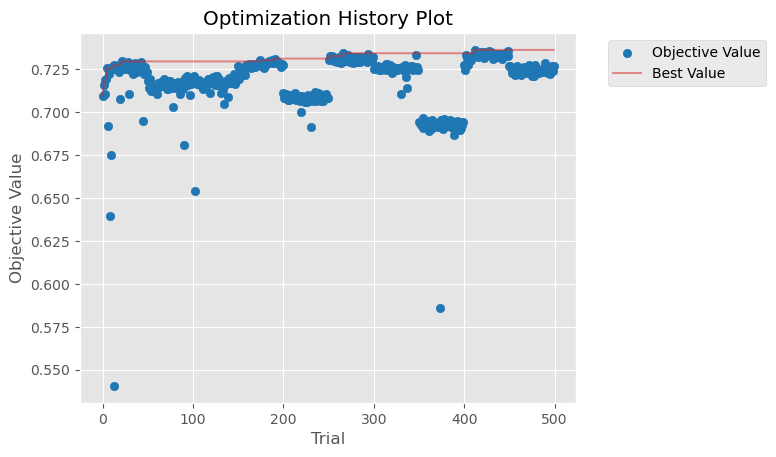

In [95]:
plot_optimization_history(study_xgb);

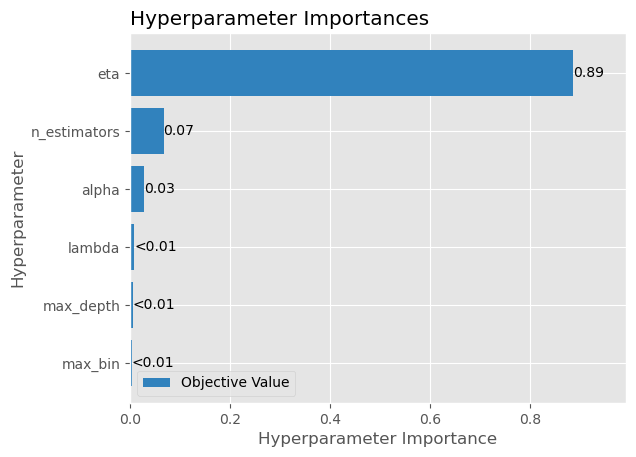

In [96]:
plot_param_importances(study_xgb);

In [97]:
detailed_objective_xgb_CV(study_xgb.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.746640,0.040852
1,TP,18.000000,3.431877
2,TN,153.700000,2.540779
3,FP,3.900000,2.183270
4,FN,15.400000,3.864367
5,Accuracy,0.898953,0.027489
6,Precision,0.820845,0.100459
7,Sensitivity,0.540216,0.109472
8,Specificity,0.975240,0.013923
9,F1 score,0.648519,0.102997


In [98]:
mat_met_xgb_test['ave'] = mat_met_xgb_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_xgb_test['std'] = mat_met_xgb_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_xgb_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.703752,0.746467,0.736627,0.749621,0.804255,0.737585,0.763038,0.783537,0.694418,0.759055,0.747836,0.033078
1,TP,34.000000,37.000000,37.000000,34.000000,42.000000,36.000000,37.000000,39.000000,38.000000,40.000000,37.400000,2.503331
2,TN,304.000000,305.000000,308.000000,307.000000,308.000000,303.000000,307.000000,308.000000,304.000000,304.000000,305.800000,1.988858
3,FP,12.000000,10.000000,6.000000,9.000000,8.000000,12.000000,9.000000,7.000000,10.000000,9.000000,9.200000,1.932184
4,FN,32.000000,30.000000,31.000000,32.000000,24.000000,31.000000,29.000000,28.000000,30.000000,29.000000,29.600000,2.366432
5,Accuracy,0.884817,0.895288,0.903141,0.892670,0.916230,0.887435,0.900524,0.908377,0.895288,0.900524,0.898429,0.009463
6,Precision,0.739130,0.787234,0.860465,0.790698,0.840000,0.750000,0.804348,0.847826,0.791667,0.816327,0.802769,0.039828
7,Sensitivity,0.515152,0.552239,0.544118,0.515152,0.636364,0.537313,0.560606,0.582090,0.558824,0.579710,0.558157,0.035786
8,Specificity,0.962000,0.968300,0.980900,0.971500,0.974700,0.961900,0.971500,0.977800,0.968200,0.971200,0.970800,0.006119
9,F1 score,0.607143,0.649123,0.666667,0.623853,0.724138,0.626087,0.660714,0.690265,0.655172,0.677966,0.658113,0.034567


In [99]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_xgb=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = xgb.XGBRegressor(objective="reg:squarederror",
                                    random_state=1121218, 
                                    booster ="gbtree", 
                                    tree_method='hist', 
                                    n_estimators = study_xgb.best_params['n_estimators'], 
                                    eta = study_xgb.best_params['eta'],
                                    max_depth = study_xgb.best_params['max_depth'], 
                                    max_bin = study_xgb.best_params['max_bin'], 
                                    reg_lambda = study_xgb.best_params['lambda'], 
                                    alpha =study_xgb.best_params['alpha'],  
                                    n_jobs=4,
                                    subsample=0.8, 
                                   )


        #learn
        eval_set = [(X_test, y_test)]
        optimizedCV_xgb.fit(X_train,y_train, 
            eval_set=eval_set,
            eval_metric=["rmse"],
            early_stopping_rounds=50,
            verbose= False,
                  )
                          
                  
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_xgb_cat = np.where(((y_pred_optimized_xgb >= 2) | (y_pred_optimized_xgb <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
        
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_run0.reset_index(inplace=True, drop=True)
xgb_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_run1.reset_index(inplace=True, drop=True)
xgb_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_run2.reset_index(inplace=True, drop=True)
xgb_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_run3.reset_index(inplace=True, drop=True)
xgb_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
xgb_5preds = pd.concat([chembl_id,xgb_run0, xgb_run1, xgb_run2, xgb_run3, xgb_run4], axis=1)
xgb_5preds = xgb_5preds[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds['y_pred_xgb_ave'] = xgb_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds['y_pred_xgb_std'] = xgb_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_xgb

,Metric,Value (average),Value (std)
0,R2,0.743689,0.042574
1,Accuracy,0.901257,0.018951
2,Precision,0.826090,0.075087
3,Sensitivity,0.555207,0.089177
4,Specificity,0.974622,0.013132
5,F1 score,0.660056,0.074731
6,F1 score (weighted),0.892834,0.021895
7,F1 score (macro),0.801119,0.042481
8,Balanced Accuracy,0.764908,0.044864
9,MCC,0.623880,0.078597


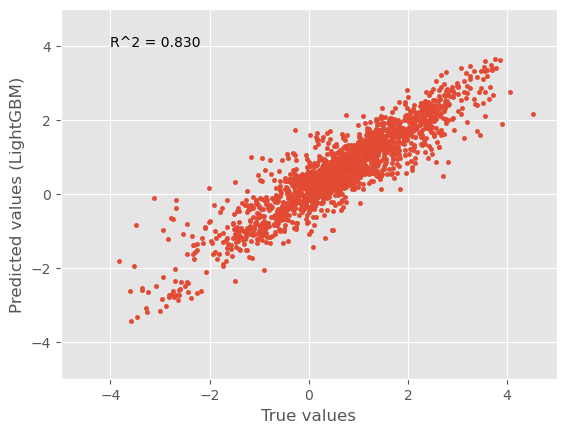

In [100]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(xgb_5preds['y_test0'], xgb_5preds['y_pred_xgb_ave'])), (-4, 4))
plt.show()

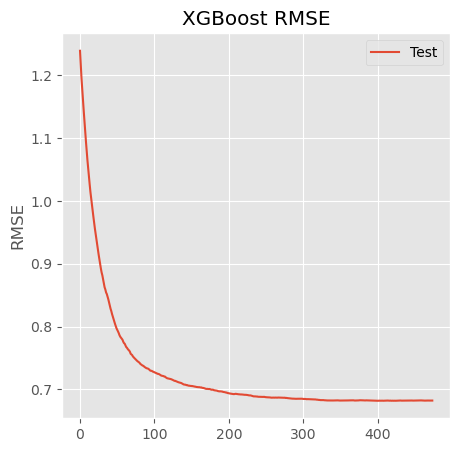

In [101]:
from matplotlib import pyplot
import matplotlib.pyplot as plt  
# retrieve performance metrics
results = optimized_xgb_0.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

 # plot classification error
#fig, ax = pyplot.subplots(figsize=(5,5))
#ax.plot(x_axis, results['validation_0']['error'], label='Train')
#ax.plot(x_axis, results['validation_1']['error'], label='Test')
#ax.legend()
    
#pyplot.ylabel('Classification Error')
#pyplot.title('XGBoost Classification Error')
#pyplot.show()

In [102]:
#cross valide using this optimized XGBoost 
fit_params = {'early_stopping_rounds': 50, 
            'eval_set': [(X_tr, Y_tr), (X_te, Y_te)],
              'verbose' : False,
             }

xgb_baseline_CVscore = cross_val_score(xgb_reg, X, Y, cv=10, scoring="r2", )
#cv_xgb_opt_testSet = cross_val_score(optimized_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
cv_xgb_opt = cross_val_score(optimizedCV_xgb, X, Y, cv=10, scoring="r2", fit_params = fit_params)
print("XGBoost baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(xgb_baseline_CVscore), np.std(xgb_baseline_CVscore, ddof=1)))
#print("XGBoost optimized model (tested with Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_xgb_opt_testSet.mean(), cv_xgb_opt_testSet.std()))
print("XGBoost optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_xgb_opt), np.std(cv_xgb_opt, ddof=1)))

XGBoost baseline model r2_score 0.7119 with a standard deviation of 0.0570
XGBoost optimized model r2_score 0.7465 with a standard deviation of 0.0520


In [103]:
joblib.dump(xgb_reg, "OUTPUT/xgb_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_xgb, "OUTPUT/optimizedCV_xgb_withSemiSel.joblib")

['OUTPUT/optimizedCV_xgb_withSemiSel.joblib']

## KNeighbors (KNN)

In [104]:
%%time


r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_reg = KNeighborsRegressor()
    
    knn_reg.fit(X_train,y_train)

    y_pred = knn_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.3
    y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
    y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.697252     0.057759
1                    TP        19.100000     4.012481
2                    TN       152.000000     2.905933
3                    FP         5.600000     2.547330
4                    FN        14.300000     4.423423
5              Accuracy         0.895812     0.025821
6             Precision         0.779388     0.100840
7           Sensitivity         0.573288     0.128191
8           Specificity         0.964440     0.016255
9              F1 score         0.652873     0.099429
10  F1 score (weighted)         0.888489     0.029751
11     F1 score (macro)         0.795743     0.056707
12    Balanced Accuracy         0.768868     0.063890
13                  MCC         0.607964     0.105142
14                  NPV         0.914520     0.024477
15              ROC_AUC         0.768868     0.063890
CPU times: user 1.17 s, sys: 3.11 s, total: 4.28 s
Wall time: 141 ms


In [105]:
def objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 5, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        
    }
    
   
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=4)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)

In [106]:
def detailed_objective_knn_CV(trial, X, Y, Y_class):
    param_grid = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 1, 30),
        "weights" :trial.suggest_categorical("weights", ['uniform', 'distance']),
        "metric" : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        "leaf_size": trial.suggest_int("leaf_size", 20, 100)
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),      
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1121218)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        knn_model = KNeighborsRegressor(**param_grid, n_jobs=4)
        knn_model.fit(X_train,y_train)
    
        y_pred = knn_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
    

In [107]:
#Execute optuna and set hyperparameters
study_knn = optuna.create_study(direction='maximize', study_name="KNNregressor")
func_knn_0 = lambda trial: objective_knn_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_knn.optimize(func_knn_0, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:54:16,929] A new study created in memory with name: KNNregressor
[I 2023-12-20 17:54:17,276] Trial 0 finished with value: 0.5984275411858129 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 21}. Best is trial 0 with value: 0.5984275411858129.
[I 2023-12-20 17:54:17,438] Trial 1 finished with value: 0.6293071359177043 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 78}. Best is trial 1 with value: 0.6293071359177043.
[I 2023-12-20 17:54:17,592] Trial 2 finished with value: 0.6395460895824618 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 35}. Best is trial 2 with value: 0.6395460895824618.
[I 2023-12-20 17:54:17,883] Trial 3 finished with value: 0.575478217639919 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 52}. Best is trial 2 with value: 0.6395460895824618.
[I 2023-12-20 17:54:18,037

	Number of trials: 50.0
	Best value (r2_score): 0.6778
	Best params:
		n_neighbors: 5
		weights: uniform
		metric: minkowski
		leaf_size: 37


In [108]:
#Create an instance with tuned hyperparameters

optimized_knn_0 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_0.fit(X_trainSet0,Y_trainSet0, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_0 = optimized_knn_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_knn_0)
# now convert the resuls to binary with cutoff 
Y_testSet0_cat = np.where(((Y_testSet0>=2) | (Y_testSet0<=-2)), 1, 0) 
y_pred_knn_0_cat = np.where(((y_pred_knn_0 >= 2) | (y_pred_knn_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_knn_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_knn_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_knn_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_knn_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_knn_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_knn_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_knn_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_knn_0_cat)
    

mat_met_knn_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_knn_test)


                 Metric        Set0
0                    R2    0.685239
1                    TP   40.000000
2                    TN  307.000000
3                    FP    9.000000
4                    FN   26.000000
5              Accuracy    0.908377
6             Precision    0.816327
7           Sensitivity    0.606061
8           Specificity    0.971500
9              F1 score    0.695652
10  F1 score (weighted)    0.902805
11     F1 score (macro)    0.820862
12    Balanced Accuracy    0.788790
13                  MCC    0.652991
14                  NPV    0.921900
15              ROC_AUC    0.788790


In [109]:
#Execute optuna and set hyperparameters

func_knn_1 = lambda trial: objective_knn_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_knn.optimize(func_knn_1, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:54:26,373] Trial 50 finished with value: 0.667983204403327 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 30}. Best is trial 10 with value: 0.6778214961865662.
[I 2023-12-20 17:54:26,550] Trial 51 finished with value: 0.6707498392668896 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 44}. Best is trial 10 with value: 0.6778214961865662.
[I 2023-12-20 17:54:26,726] Trial 52 finished with value: 0.6707498392668896 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 39}. Best is trial 10 with value: 0.6778214961865662.
[I 2023-12-20 17:54:26,901] Trial 53 finished with value: 0.6430792565257057 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski', 'leaf_size': 45}. Best is trial 10 with value: 0.6778214961865662.
[I 2023-12-20 17:54:27,077] Trial 54 finished with value: 0.667983204403327 and parameters: {'n_neighbors

	Number of trials: 100.0
	Best value (r2_score): 0.6863
	Best params:
		n_neighbors: 5
		weights: distance
		metric: euclidean
		leaf_size: 27


In [110]:
#Create an instance with tuned hyperparameters

optimized_knn_1 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_1.fit(X_trainSet1,Y_trainSet1, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_1 = optimized_knn_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_knn_1)
# now convert the resuls to binary with cutoff 
Y_testSet1_cat = np.where(((Y_testSet1>=2) | (Y_testSet1<=-2)), 1, 0) 
y_pred_knn_1_cat = np.where(((y_pred_knn_1 >= 2) | (y_pred_knn_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_knn_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_knn_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_knn_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_knn_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_knn_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_knn_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_knn_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_knn_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set1'] = set1
print(mat_met_knn_test)


                 Metric        Set0        Set1
0                    R2    0.685239    0.696281
1                    TP   40.000000   35.000000
2                    TN  307.000000  307.000000
3                    FP    9.000000    8.000000
4                    FN   26.000000   32.000000
5              Accuracy    0.908377    0.895288
6             Precision    0.816327    0.813953
7           Sensitivity    0.606061    0.522388
8           Specificity    0.971500    0.974600
9              F1 score    0.695652    0.636364
10  F1 score (weighted)    0.902805    0.885786
11     F1 score (macro)    0.820862    0.787601
12    Balanced Accuracy    0.788790    0.748496
13                  MCC    0.652991    0.598008
14                  NPV    0.921900    0.905600
15              ROC_AUC    0.788790    0.748496


In [111]:
#Execute optuna and set hyperparameters

func_knn_2 = lambda trial: objective_knn_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_knn.optimize(func_knn_2, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:54:35,070] Trial 100 finished with value: 0.6625311112821212 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 26}. Best is trial 59 with value: 0.6862975887785467.
[I 2023-12-20 17:54:35,243] Trial 101 finished with value: 0.6705518114270208 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 22}. Best is trial 59 with value: 0.6862975887785467.
[I 2023-12-20 17:54:35,414] Trial 102 finished with value: 0.6679170072979996 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 20}. Best is trial 59 with value: 0.6862975887785467.
[I 2023-12-20 17:54:35,580] Trial 103 finished with value: 0.6705518114270208 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 23}. Best is trial 59 with value: 0.6862975887785467.
[I 2023-12-20 17:54:35,748] Trial 104 finished with value: 0.6679170072979996 and parameters: {'

	Number of trials: 150.0
	Best value (r2_score): 0.6863
	Best params:
		n_neighbors: 5
		weights: distance
		metric: euclidean
		leaf_size: 27


In [112]:
#Create an instance with tuned hyperparameters

optimized_knn_2 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_2.fit(X_trainSet2,Y_trainSet2, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_2 = optimized_knn_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_knn_2)
# now convert the resuls to binary with cutoff 
Y_testSet2_cat = np.where(((Y_testSet2>=2) | (Y_testSet2<=-2)), 1, 0) 
y_pred_knn_2_cat = np.where(((y_pred_knn_2 >= 2) | (y_pred_knn_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_knn_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_knn_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_knn_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_knn_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_knn_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_knn_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_knn_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_knn_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set2'] = Set2
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.685239    0.696281    0.725667
1                    TP   40.000000   35.000000   37.000000
2                    TN  307.000000  307.000000  306.000000
3                    FP    9.000000    8.000000    8.000000
4                    FN   26.000000   32.000000   31.000000
5              Accuracy    0.908377    0.895288    0.897906
6             Precision    0.816327    0.813953    0.822222
7           Sensitivity    0.606061    0.522388    0.544118
8           Specificity    0.971500    0.974600    0.974500
9              F1 score    0.695652    0.636364    0.654867
10  F1 score (weighted)    0.902805    0.885786    0.889319
11     F1 score (macro)    0.820862    0.787601    0.797480
12    Balanced Accuracy    0.788790    0.748496    0.759320
13                  MCC    0.652991    0.598008    0.615409
14                  NPV    0.921900    0.905600    0.908000
15              ROC_AUC    0.788790    0

In [113]:
#Execute optuna and set hyperparameters

func_knn_3 = lambda trial: objective_knn_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_knn.optimize(func_knn_3, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:54:44,039] Trial 150 finished with value: 0.6868899983749874 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 73}. Best is trial 150 with value: 0.6868899983749874.
[I 2023-12-20 17:54:44,201] Trial 151 finished with value: 0.6868899983749874 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 150 with value: 0.6868899983749874.
[I 2023-12-20 17:54:44,372] Trial 152 finished with value: 0.6868899983749874 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 95}. Best is trial 150 with value: 0.6868899983749874.
[I 2023-12-20 17:54:44,543] Trial 153 finished with value: 0.6868899983749874 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 100}. Best is trial 150 with value: 0.6868899983749874.
[I 2023-12-20 17:54:44,715] Trial 154 finished with value: 0.6814629209957228 and paramete

	Number of trials: 200.0
	Best value (r2_score): 0.6952
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 96


In [114]:
#Create an instance with tuned hyperparameters

optimized_knn_3 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_3.fit(X_trainSet3,Y_trainSet3, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_3 = optimized_knn_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_knn_3)
# now convert the resuls to binary with cutoff 
Y_testSet3_cat = np.where(((Y_testSet3>=2) | (Y_testSet3<=-2)), 1, 0) 
y_pred_knn_3_cat = np.where(((y_pred_knn_3 >= 2) | (y_pred_knn_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_knn_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_knn_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_knn_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_knn_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_knn_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_knn_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_knn_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_knn_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set3'] = Set3
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.685239    0.696281    0.725667    0.713837
1                    TP   40.000000   35.000000   37.000000   40.000000
2                    TN  307.000000  307.000000  306.000000  306.000000
3                    FP    9.000000    8.000000    8.000000   10.000000
4                    FN   26.000000   32.000000   31.000000   26.000000
5              Accuracy    0.908377    0.895288    0.897906    0.905759
6             Precision    0.816327    0.813953    0.822222    0.800000
7           Sensitivity    0.606061    0.522388    0.544118    0.606061
8           Specificity    0.971500    0.974600    0.974500    0.968400
9              F1 score    0.695652    0.636364    0.654867    0.689655
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050
12    Balanced Accuracy    0.788790    0.748496    0.759320    0

In [115]:
#Execute optuna and set hyperparameters

func_knn_4 = lambda trial: objective_knn_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_knn.optimize(func_knn_4, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:54:58,764] Trial 200 finished with value: 0.6785602554463452 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 85}. Best is trial 169 with value: 0.6951910825697657.
[I 2023-12-20 17:54:59,141] Trial 201 finished with value: 0.6783538774436153 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 81}. Best is trial 169 with value: 0.6951910825697657.
[I 2023-12-20 17:54:59,533] Trial 202 finished with value: 0.6783538774436153 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 82}. Best is trial 169 with value: 0.6951910825697657.
[I 2023-12-20 17:54:59,916] Trial 203 finished with value: 0.6783538774436153 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 169 with value: 0.6951910825697657.
[I 2023-12-20 17:55:00,296] Trial 204 finished with value: 0.6783538774436153 and parameters

	Number of trials: 250.0
	Best value (r2_score): 0.6952
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 96


In [116]:
#Create an instance with tuned hyperparameters

optimized_knn_4 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_4.fit(X_trainSet4,Y_trainSet4, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_4 = optimized_knn_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_knn_4)
# now convert the resuls to binary with cutoff 
Y_testSet4_cat = np.where(((Y_testSet4>=2) | (Y_testSet4<=-2)), 1, 0) 
y_pred_knn_4_cat = np.where(((y_pred_knn_4 >= 2) | (y_pred_knn_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_knn_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_knn_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_knn_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_knn_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_knn_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_knn_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_knn_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_knn_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set4'] = Set4
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.685239    0.696281    0.725667    0.713837   
1                    TP   40.000000   35.000000   37.000000   40.000000   
2                    TN  307.000000  307.000000  306.000000  306.000000   
3                    FP    9.000000    8.000000    8.000000   10.000000   
4                    FN   26.000000   32.000000   31.000000   26.000000   
5              Accuracy    0.908377    0.895288    0.897906    0.905759   
6             Precision    0.816327    0.813953    0.822222    0.800000   
7           Sensitivity    0.606061    0.522388    0.544118    0.606061   
8           Specificity    0.971500    0.974600    0.974500    0.968400   
9              F1 score    0.695652    0.636364    0.654867    0.689655   
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423   
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050   
12    Balanced Accuracy  

In [117]:
#Execute optuna and set hyperparameters

func_knn_5 = lambda trial: objective_knn_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_knn.optimize(func_knn_5, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:55:18,058] Trial 250 finished with value: 0.6970573093210177 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 250 with value: 0.6970573093210177.
[I 2023-12-20 17:55:18,419] Trial 251 finished with value: 0.6973312697872558 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:18,792] Trial 252 finished with value: 0.6973312697872558 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:19,147] Trial 253 finished with value: 0.692933179363802 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:19,546] Trial 254 finished with value: 0.692933179363802 and parameters: 

	Number of trials: 300.0
	Best value (r2_score): 0.6973
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 97


In [118]:
#Create an instance with tuned hyperparameters

optimized_knn_5 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_5.fit(X_trainSet5,Y_trainSet5, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_5 = optimized_knn_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_knn_5)
# now convert the resuls to binary with cutoff 
Y_testSet5_cat = np.where(((Y_testSet5>=2) | (Y_testSet5<=-2)), 1, 0) 
y_pred_knn_5_cat = np.where(((y_pred_knn_5 >= 2) | (y_pred_knn_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_knn_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_knn_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_knn_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_knn_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_knn_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_knn_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_knn_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_knn_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set5'] = Set5
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.685239    0.696281    0.725667    0.713837   
1                    TP   40.000000   35.000000   37.000000   40.000000   
2                    TN  307.000000  307.000000  306.000000  306.000000   
3                    FP    9.000000    8.000000    8.000000   10.000000   
4                    FN   26.000000   32.000000   31.000000   26.000000   
5              Accuracy    0.908377    0.895288    0.897906    0.905759   
6             Precision    0.816327    0.813953    0.822222    0.800000   
7           Sensitivity    0.606061    0.522388    0.544118    0.606061   
8           Specificity    0.971500    0.974600    0.974500    0.968400   
9              F1 score    0.695652    0.636364    0.654867    0.689655   
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423   
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050   
12    Balanced Accuracy  

In [119]:
#Execute optuna and set hyperparameters

func_knn_6 = lambda trial: objective_knn_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_knn.optimize(func_knn_6, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:55:37,386] Trial 300 finished with value: 0.6816402731286116 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 97}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:37,732] Trial 301 finished with value: 0.6851246090752852 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 95}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:38,080] Trial 302 finished with value: 0.6851246090752852 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 91}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:38,458] Trial 303 finished with value: 0.6374197533147428 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:38,806] Trial 304 finished with value: 0.6851246090752852 and parameters

	Number of trials: 350.0
	Best value (r2_score): 0.6973
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 97


In [120]:
#Create an instance with tuned hyperparameters

optimized_knn_6 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_6.fit(X_trainSet6,Y_trainSet6, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_6 = optimized_knn_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_knn_6)
# now convert the resuls to binary with cutoff 
Y_testSet6_cat = np.where(((Y_testSet6>=2) | (Y_testSet6<=-2)), 1, 0) 
y_pred_knn_6_cat = np.where(((y_pred_knn_6 >= 2) | (y_pred_knn_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_knn_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_knn_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_knn_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_knn_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_knn_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_knn_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_knn_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_knn_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set6'] = Set6
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.685239    0.696281    0.725667    0.713837   
1                    TP   40.000000   35.000000   37.000000   40.000000   
2                    TN  307.000000  307.000000  306.000000  306.000000   
3                    FP    9.000000    8.000000    8.000000   10.000000   
4                    FN   26.000000   32.000000   31.000000   26.000000   
5              Accuracy    0.908377    0.895288    0.897906    0.905759   
6             Precision    0.816327    0.813953    0.822222    0.800000   
7           Sensitivity    0.606061    0.522388    0.544118    0.606061   
8           Specificity    0.971500    0.974600    0.974500    0.968400   
9              F1 score    0.695652    0.636364    0.654867    0.689655   
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423   
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050   
12    Balanced Accuracy  

In [121]:
#Execute optuna and set hyperparameters

func_knn_7 = lambda trial: objective_knn_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_knn.optimize(func_knn_7, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:55:55,551] Trial 350 finished with value: 0.6662667190732022 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 98}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:55,936] Trial 351 finished with value: 0.6089011367952779 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:56,326] Trial 352 finished with value: 0.6613483023486222 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:56,726] Trial 353 finished with value: 0.6662667190732022 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 94}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:55:57,131] Trial 354 finished with value: 0.6662667190732022 and parameter

	Number of trials: 400.0
	Best value (r2_score): 0.6973
	Best params:
		n_neighbors: 6
		weights: distance
		metric: manhattan
		leaf_size: 97


In [122]:
#Create an instance with tuned hyperparameters

optimized_knn_7 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_7.fit(X_trainSet7,Y_trainSet7, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_7 = optimized_knn_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_knn_7)
# now convert the resuls to binary with cutoff 
Y_testSet7_cat = np.where(((Y_testSet7>=2) | (Y_testSet7<=-2)), 1, 0) 
y_pred_knn_7_cat = np.where(((y_pred_knn_7 >= 2) | (y_pred_knn_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_knn_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_knn_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_knn_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_knn_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_knn_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_knn_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_knn_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_knn_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set7'] = Set7
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.685239    0.696281    0.725667    0.713837   
1                    TP   40.000000   35.000000   37.000000   40.000000   
2                    TN  307.000000  307.000000  306.000000  306.000000   
3                    FP    9.000000    8.000000    8.000000   10.000000   
4                    FN   26.000000   32.000000   31.000000   26.000000   
5              Accuracy    0.908377    0.895288    0.897906    0.905759   
6             Precision    0.816327    0.813953    0.822222    0.800000   
7           Sensitivity    0.606061    0.522388    0.544118    0.606061   
8           Specificity    0.971500    0.974600    0.974500    0.968400   
9              F1 score    0.695652    0.636364    0.654867    0.689655   
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423   
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050   
12    Balanced Accuracy  

In [123]:
#Execute optuna and set hyperparameters

func_knn_8 = lambda trial: objective_knn_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_knn.optimize(func_knn_8, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:56:14,700] Trial 400 finished with value: 0.5887496779240705 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 92}. Best is trial 251 with value: 0.6973312697872558.
[I 2023-12-20 17:56:15,120] Trial 401 finished with value: 0.7077316489716907 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 96}. Best is trial 401 with value: 0.7077316489716907.
[I 2023-12-20 17:56:15,531] Trial 402 finished with value: 0.7133560567201337 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 99}. Best is trial 402 with value: 0.7133560567201337.
[I 2023-12-20 17:56:15,904] Trial 403 finished with value: 0.7153585358923547 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'leaf_size': 100}. Best is trial 403 with value: 0.7153585358923547.
[I 2023-12-20 17:56:16,307] Trial 404 finished with value: 0.7153585358923547 and paramete

	Number of trials: 450.0
	Best value (r2_score): 0.7154
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 100


In [124]:
#Create an instance with tuned hyperparameters

optimized_knn_8 =  KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_8.fit(X_trainSet8,Y_trainSet8, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_8 = optimized_knn_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_knn_8)
# now convert the resuls to binary with cutoff 
Y_testSet8_cat = np.where(((Y_testSet8>=2) | (Y_testSet8<=-2)), 1, 0) 
y_pred_knn_8_cat = np.where(((y_pred_knn_8 >= 2) | (y_pred_knn_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_knn_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_knn_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_knn_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_knn_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_knn_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_knn_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_knn_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_knn_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set8'] = Set8
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.685239    0.696281    0.725667    0.713837   
1                    TP   40.000000   35.000000   37.000000   40.000000   
2                    TN  307.000000  307.000000  306.000000  306.000000   
3                    FP    9.000000    8.000000    8.000000   10.000000   
4                    FN   26.000000   32.000000   31.000000   26.000000   
5              Accuracy    0.908377    0.895288    0.897906    0.905759   
6             Precision    0.816327    0.813953    0.822222    0.800000   
7           Sensitivity    0.606061    0.522388    0.544118    0.606061   
8           Specificity    0.971500    0.974600    0.974500    0.968400   
9              F1 score    0.695652    0.636364    0.654867    0.689655   
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423   
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050   
12    Balanced Accuracy  

In [125]:
#Execute optuna and set hyperparameters

func_knn_9 = lambda trial: objective_knn_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_knn.optimize(func_knn_9, n_trials=50)
print(f"\tNumber of trials: {len(study_knn.trials):.1f}")
print(f"\tBest value (r2_score): {study_knn.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_knn.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:56:26,509] Trial 450 finished with value: 0.6865237626104144 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 99}. Best is trial 403 with value: 0.7153585358923547.
[I 2023-12-20 17:56:26,698] Trial 451 finished with value: 0.6865237626104144 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 99}. Best is trial 403 with value: 0.7153585358923547.
[I 2023-12-20 17:56:26,884] Trial 452 finished with value: 0.6865237626104144 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 100}. Best is trial 403 with value: 0.7153585358923547.
[I 2023-12-20 17:56:27,072] Trial 453 finished with value: 0.6865237626104144 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'minkowski', 'leaf_size': 99}. Best is trial 403 with value: 0.7153585358923547.
[I 2023-12-20 17:56:27,260] Trial 454 finished with value: 0.6865237626104144 and parameter

	Number of trials: 500.0
	Best value (r2_score): 0.7154
	Best params:
		n_neighbors: 5
		weights: distance
		metric: manhattan
		leaf_size: 100


In [126]:
#Create an instance with tuned hyperparameters

optimized_knn_9 = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )

    
#learn


optimized_knn_9.fit(X_trainSet9,Y_trainSet9, )

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_knn_9 = optimized_knn_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_knn_9)
# now convert the resuls to binary with cutoff 
Y_testSet9_cat = np.where(((Y_testSet9>=2) | (Y_testSet9<=-2)), 1, 0) 
y_pred_knn_9_cat = np.where(((y_pred_knn_9 >= 2) | (y_pred_knn_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_knn_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_knn_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_knn_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_knn_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_knn_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_knn_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_knn_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_knn_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                      })   

mat_met_knn_test['Set9'] = Set9
print(mat_met_knn_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.685239    0.696281    0.725667    0.713837   
1                    TP   40.000000   35.000000   37.000000   40.000000   
2                    TN  307.000000  307.000000  306.000000  306.000000   
3                    FP    9.000000    8.000000    8.000000   10.000000   
4                    FN   26.000000   32.000000   31.000000   26.000000   
5              Accuracy    0.908377    0.895288    0.897906    0.905759   
6             Precision    0.816327    0.813953    0.822222    0.800000   
7           Sensitivity    0.606061    0.522388    0.544118    0.606061   
8           Specificity    0.971500    0.974600    0.974500    0.968400   
9              F1 score    0.695652    0.636364    0.654867    0.689655   
10  F1 score (weighted)    0.902805    0.885786    0.889319    0.900423   
11     F1 score (macro)    0.820862    0.787601    0.797480    0.817050   
12    Balanced Accuracy  

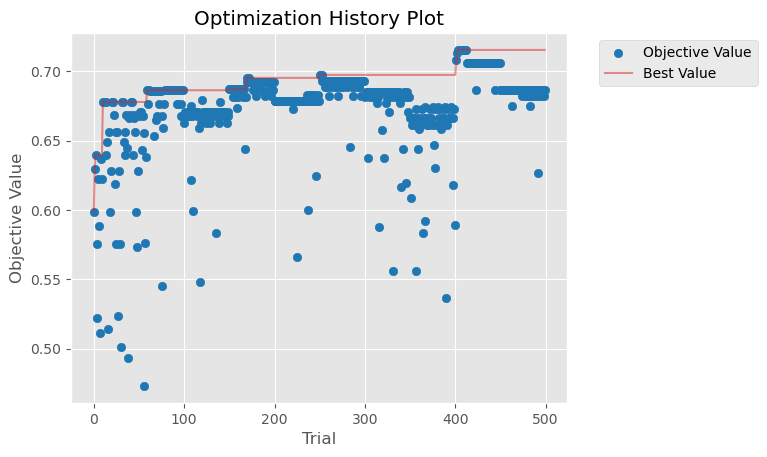

In [127]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_knn);

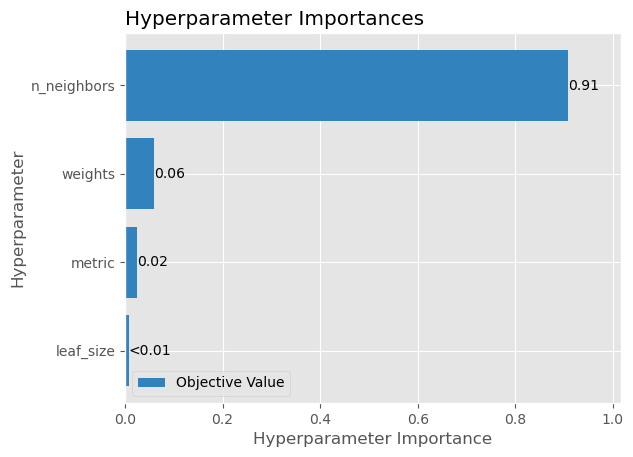

In [128]:

plot_param_importances(study_knn);

In [129]:
detailed_objective_knn_CV(study_knn.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.715725,0.059646
1,TP,20.600000,2.836273
2,TN,152.200000,2.936362
3,FP,5.400000,2.590581
4,FN,12.800000,3.326660
5,Accuracy,0.904712,0.021058
6,Precision,0.799669,0.089643
7,Sensitivity,0.618062,0.094033
8,Specificity,0.965720,0.016518
9,F1 score,0.692387,0.070095


In [130]:
mat_met_knn_test['ave'] = mat_met_knn_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_knn_test['std'] = mat_met_knn_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_knn_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.685239,0.696281,0.725667,0.713837,0.785704,0.713344,0.753293,0.741681,0.683498,0.712557,0.721110,0.031896
1,TP,40.000000,35.000000,37.000000,40.000000,42.000000,38.000000,34.000000,42.000000,39.000000,41.000000,38.800000,2.780887
2,TN,307.000000,307.000000,306.000000,306.000000,306.000000,305.000000,307.000000,306.000000,304.000000,306.000000,306.000000,0.942809
3,FP,9.000000,8.000000,8.000000,10.000000,10.000000,10.000000,9.000000,9.000000,10.000000,7.000000,9.000000,1.054093
4,FN,26.000000,32.000000,31.000000,26.000000,24.000000,29.000000,32.000000,25.000000,29.000000,28.000000,28.200000,2.898275
5,Accuracy,0.908377,0.895288,0.897906,0.905759,0.910995,0.897906,0.892670,0.910995,0.897906,0.908377,0.902618,0.006959
6,Precision,0.816327,0.813953,0.822222,0.800000,0.807692,0.791667,0.790698,0.823529,0.795918,0.854167,0.811617,0.019221
7,Sensitivity,0.606061,0.522388,0.544118,0.606061,0.636364,0.567164,0.515152,0.626866,0.573529,0.594203,0.579190,0.042092
8,Specificity,0.971500,0.974600,0.974500,0.968400,0.968400,0.968300,0.971500,0.971400,0.968200,0.977600,0.971440,0.003268
9,F1 score,0.695652,0.636364,0.654867,0.689655,0.711864,0.660870,0.623853,0.711864,0.666667,0.700855,0.675251,0.031288


In [131]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_knn=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = KNeighborsRegressor(n_neighbors = study_knn.best_params['n_neighbors'],
                                                  weights= study_knn.best_params['weights'],
                                                  metric= study_knn.best_params['metric'],
                                                  leaf_size= study_knn.best_params['leaf_size'],
                                                  n_jobs=4,
                                                 )


        #learn
        
        optimizedCV_knn.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_knn_cat = np.where(((y_pred_optimized_knn >= 2) | (y_pred_optimized_knn <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
        
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_run0.sort_values(by='y_test_idx0', inplace=True)
knn_run0.reset_index(inplace=True, drop=True)
knn_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_run1.sort_values(by='y_test_idx1', inplace=True)
knn_run1.reset_index(inplace=True, drop=True)
knn_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_run2.sort_values(by='y_test_idx2', inplace=True)
knn_run2.reset_index(inplace=True, drop=True)
knn_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_run3.sort_values(by='y_test_idx3', inplace=True)
knn_run3.reset_index(inplace=True, drop=True)
knn_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_run4.sort_values(by='y_test_idx4', inplace=True)
knn_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
knn_5preds = pd.concat([chembl_id,knn_run0, knn_run1, knn_run2, knn_run3, knn_run4], axis=1)
knn_5preds = knn_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds['y_pred_knn_ave'] = knn_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds['y_pred_knn_std'] = knn_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_knn

,Metric,Value (average),Value (std)
0,R2,0.716345,0.044662
1,Accuracy,0.907539,0.019493
2,Precision,0.807920,0.071567
3,Sensitivity,0.622207,0.098350
4,Specificity,0.968032,0.013990
5,F1 score,0.698581,0.074945
6,F1 score (weighted),0.902197,0.022024
7,F1 score (macro),0.821957,0.042803
8,Balanced Accuracy,0.795116,0.048878
9,MCC,0.655744,0.080368


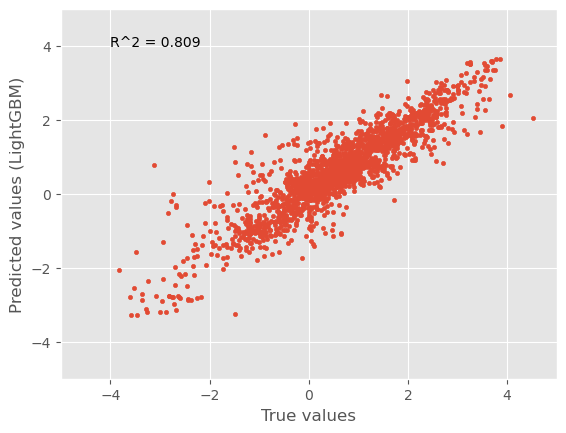

In [132]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(knn_5preds['y_test0'], knn_5preds['y_pred_knn_ave'])), (-4, 4))
plt.show()

In [133]:
#cross valide using this optimized KNN 
knn_baseline_CVscore = cross_val_score(knn_reg, X, Y, cv=10, scoring="r2")
#cv_knn_opt_testSet = cross_val_score(optimized_knn, X, Y, cv=10, scoring="r2")
cv_knn_opt = cross_val_score(optimizedCV_knn, X, Y, cv=10, scoring="r2")
print("KNN baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(knn_baseline_CVscore), np.std(knn_baseline_CVscore, ddof=1)))
#print("KNN optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (cv_knn_opt_testSet.mean(), cv_knn_opt_testSet.std()))
print("KNN optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_knn_opt), np.std(cv_knn_opt, ddof=1)))

KNN baseline model r2_score 0.6998 with a standard deviation of 0.0551
KNN optimized model r2_score 0.7178 with a standard deviation of 0.0508


In [134]:
joblib.dump(knn_reg, "OUTPUT/knn_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_knn, "OUTPUT/optimizedCV_knn_withSemiSel.joblib")

['OUTPUT/optimizedCV_knn_withSemiSel.joblib']

## Support Vector 

In [135]:
%%time

r2_scores = np.empty(10)
TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)
Accuracy = np.empty(10)
Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
f1_scores = np.empty(10)
f1_scores_W = np.empty(10)
f1_scores_M = np.empty(10)
BA_scores = np.empty(10)
MCC = np.empty(10)
NPV = np.empty(10)
ROC_AUC= np.empty(10)



for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    svm_reg = SVR()
    
    svm_reg.fit(X_train, y_train, )

    y_pred = svm_reg.predict(X_test) 
    # r2 score of the regression model before evaluating categorical evaluation parameters
    r2_scores[idx] = r2_score(y_test, y_pred)
    # now convert the resuls to binary with cutoff 6.3
    y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
    y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
    #calculate the evaluation results
    conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
    TP[idx] = conf_matrix[1][1]
    TN[idx] = conf_matrix[0][0]
    FP[idx] = conf_matrix[0][1] 
    FN[idx] = conf_matrix[1][0]
    Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
    Precision[idx] = precision_score(y_test_cat, y_pred_cat)
    Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
    Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
    f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
    f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
    f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
    BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
    MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
    NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
    ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       }) 
    
print(mat_met)


                 Metric  Value (average)  Value (std)
0                    R2         0.709571     0.045627
1                    TP        13.800000     2.859681
2                    TN       155.200000     1.475730
3                    FP         2.400000     1.173788
4                    FN        19.600000     3.533962
5              Accuracy         0.884817     0.018304
6             Precision         0.856817     0.072007
7           Sensitivity         0.414856     0.094215
8           Specificity         0.984770     0.007458
9              F1 score         0.552734     0.088583
10  F1 score (weighted)         0.866973     0.024921
11     F1 score (macro)         0.743297     0.049138
12    Balanced Accuracy         0.699815     0.046517
13                  MCC         0.542525     0.076567
14                  NPV         0.888140     0.018340
15              ROC_AUC         0.699815     0.046517
CPU times: user 3.53 s, sys: 4 ms, total: 3.53 s
Wall time: 3.53 s


In [136]:
def objective_svm_CV(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    
    cv_scores=np.empty(10)
    
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
    
    
        cv_scores[idx] = r2_score(y_test, y_pred)
       
        
    return np.mean(cv_scores)


In [137]:
def detailed_objective_svm_cv(trial, X, Y, Y_class):
    param_grid = {
        "C" : trial.suggest_categorical("C", [np.exp2(-7), np.exp2(-6), np.exp2(-5), np.exp2(-4), np.exp2(-3), np.exp2(-2),
                                              np.exp2(-1), np.exp2(0), np.exp2(1), np.exp2(2), np.exp2(3), np.exp2(4),
                                             np.exp2(5), np.exp2(6), np.exp2(7)]),
        "gamma" :trial.suggest_categorical("gamma", [np.exp2(-15), np.exp2(-14), np.exp2(-13), np.exp2(-12), np.exp2(-11), 
                                                     np.exp2(-10),np.exp2(-9), np.exp2(-8), np.exp2(-7), np.exp2(-6), np.exp2(-5), 
                                                     np.exp2(-4),np.exp2(-3), np.exp2(-2), np.exp2(-1), np.exp2(0), np.exp2(1),
                                                     np.exp2(2), np.exp2(3)]),
        #"kernel" : trial.suggest_categorical("kernel", ['linear', 'rbf', 'sigmoid']),
        #"degree": trial.suggest_int("degree", 3, 10)
        #"device_type": trial.suggest_categorical("device_type", ['gpu'])
        
    }
    
    r2_scores = np.empty(10)
    TP =np.empty(10)
    TN = np.empty(10)
    FP = np.empty(10)
    FN = np.empty(10)
    Accuracy = np.empty(10)
    Precision = np.empty(10) #Also called Positive Predictive Value(PPV)
    Sensitivity = np.empty(10) # Also called Recall or True Positive Rate (TPR)
    Specificity = np.empty(10) #Also called selectivity or True Negative Rate  (TNR)
    f1_scores = np.empty(10)
    f1_scores_W = np.empty(10)
    f1_scores_M = np.empty(10)
    BA_scores = np.empty(10)
    MCC = np.empty(10)
    NPV = np.empty(10)
    ROC_AUC= np.empty(10)

    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        svm_model = SVR(**param_grid)
        svm_model.fit(X_train,y_train)
    
        y_pred = svm_model.predict(X_test)
        
        # r2 score of the regression model before evaluating categorical evaluation parameters
        r2_scores[idx] = r2_score(y_test, y_pred)
        # now convert the resuls to binary with cutoff 6.3
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_cat = np.where(((y_pred >= 2) | (y_pred <= -2)), 1, 0)
        #calculate the evaluation results
        conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        Accuracy[idx] = accuracy_score(y_test_cat, y_pred_cat)
        Precision[idx] = precision_score(y_test_cat, y_pred_cat)
        Sensitivity[idx] = recall_score(y_test_cat, y_pred_cat)
        Specificity[idx] = round( TN[idx] / (TN[idx]+FP[idx]),4 )
        f1_scores[idx] = f1_score(y_test_cat, y_pred_cat)
        f1_scores_W[idx] = f1_score(y_test_cat, y_pred_cat, average="weighted")
        f1_scores_M[idx] = f1_score(y_test_cat, y_pred_cat, average="macro")
        BA_scores[idx] = balanced_accuracy_score(y_test_cat, y_pred_cat)
        MCC[idx] = matthews_corrcoef(y_test_cat, y_pred_cat)
        NPV[idx] = round( TN[idx] / (TN[idx]+FN[idx]),4 )
        ROC_AUC[idx] = roc_auc_score(y_test_cat, y_pred_cat)


    mat_met = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        'Value (std)': [ np.std(r2_scores, ddof=1), np.std(TP,ddof=1),np.std(TN,ddof=1),np.std(FP,ddof=1),np.std(FN, ddof=1),
                                        np.std(Accuracy, ddof=1),np.std(Precision, ddof=1),
                                        np.std(Sensitivity,ddof=1),np.std(Specificity,ddof=1),np.std(f1_scores, ddof=1),
                                        np.std(f1_scores_W, ddof=1),np.std(f1_scores_M, ddof=1), np.std(BA_scores, ddof=1), 
                                        np.std(MCC, ddof=1),np.std(NPV, ddof=1),np.std(ROC_AUC, ddof=1)]
                       })  
    
    return(mat_met)
   

In [138]:
#Execute optuna and set hyperparameters
study_svm = optuna.create_study(direction='maximize', study_name="SVM_regressor_CV")
func_svm_0 = lambda trial: objective_svm_CV(trial, X_trainSet0, Y_trainSet0, Y_trainSet0_class)
study_svm.optimize(func_svm_0, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:56:44,232] A new study created in memory with name: SVM_regressor_CV
[I 2023-12-20 17:56:47,042] Trial 0 finished with value: 0.26271054034863967 and parameters: {'C': 2.0, 'gamma': 0.125}. Best is trial 0 with value: 0.26271054034863967.
[I 2023-12-20 17:56:49,662] Trial 1 finished with value: 0.11194540511629972 and parameters: {'C': 0.125, 'gamma': 0.00048828125}. Best is trial 0 with value: 0.26271054034863967.
[I 2023-12-20 17:56:52,127] Trial 2 finished with value: 0.5953023024641206 and parameters: {'C': 8.0, 'gamma': 0.00048828125}. Best is trial 2 with value: 0.5953023024641206.
[I 2023-12-20 17:56:54,728] Trial 3 finished with value: 0.4782182445944068 and parameters: {'C': 8.0, 'gamma': 0.0001220703125}. Best is trial 2 with value: 0.5953023024641206.
[I 2023-12-20 17:56:57,346] Trial 4 finished with value: 0.5945589748025306 and parameters: {'C': 0.5, 'gamma': 0.0078125}. Best is trial 2 with value: 0.5953023024641206.
[I 2023-12-20 17:57:00,178] Trial 5 fi

	Number of trials: 50.0
	Best value (r2_score): 0.7083
	Best params:
		C: 32.0
		gamma: 0.015625


In [139]:
#Create an instance with tuned hyperparameters

optimized_svm_0 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_0.fit(X_trainSet0,Y_trainSet0,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_0 = optimized_svm_0.predict(X_testSet0)
r2_scores = r2_score(Y_testSet0, y_pred_svm_0)
# now convert the resuls to binary with cutoff 6.3
Y_testSet0_cat = np.where(((Y_testSet0>=2) | (Y_testSet0<=-2)), 1, 0) 
y_pred_svm_0_cat = np.where(((y_pred_svm_0 >= 2) | (y_pred_svm_0 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet0_cat, y_pred_svm_0_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
Precision = precision_score(Y_testSet0_cat, y_pred_svm_0_cat)
Sensitivity = recall_score(Y_testSet0_cat, y_pred_svm_0_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet0_cat, y_pred_svm_0_cat)      
f1_scores_W = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet0_cat, y_pred_svm_0_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet0_cat, y_pred_svm_0_cat)
MCC = matthews_corrcoef(Y_testSet0_cat, y_pred_svm_0_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet0_cat, y_pred_svm_0_cat)
    

mat_met_svm_test = pd.DataFrame({'Metric':['R2','TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Set0':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })    
print(mat_met_svm_test)


                 Metric        Set0
0                    R2    0.709863
1                    TP   33.000000
2                    TN  309.000000
3                    FP    7.000000
4                    FN   33.000000
5              Accuracy    0.895288
6             Precision    0.825000
7           Sensitivity    0.500000
8           Specificity    0.977800
9              F1 score    0.622642
10  F1 score (weighted)    0.884515
11     F1 score (macro)    0.780926
12    Balanced Accuracy    0.738924
13                  MCC    0.590014
14                  NPV    0.903500
15              ROC_AUC    0.738924


In [140]:
#Execute optuna and set hyperparameters
func_svm_1 = lambda trial: objective_svm_CV(trial, X_trainSet1, Y_trainSet1, Y_trainSet1_class)
study_svm.optimize(func_svm_1, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 17:59:01,914] Trial 50 finished with value: 0.6989863514415173 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 39 with value: 0.7083467362631212.
[I 2023-12-20 17:59:04,409] Trial 51 finished with value: 0.6989863514415173 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 39 with value: 0.7083467362631212.
[I 2023-12-20 17:59:06,908] Trial 52 finished with value: 0.6989863514415173 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 39 with value: 0.7083467362631212.
[I 2023-12-20 17:59:09,414] Trial 53 finished with value: 0.031332534639814835 and parameters: {'C': 0.25, 'gamma': 6.103515625e-05}. Best is trial 39 with value: 0.7083467362631212.
[I 2023-12-20 17:59:11,959] Trial 54 finished with value: 0.636413509533387 and parameters: {'C': 32.0, 'gamma': 0.00048828125}. Best is trial 39 with value: 0.7083467362631212.
[I 2023-12-20 17:59:14,429] Trial 55 finished with value: 0.7019156841782396 and parameters: {'C': 8.0, 'gamma': 0.01

	Number of trials: 100.0
	Best value (r2_score): 0.7083
	Best params:
		C: 32.0
		gamma: 0.015625


In [141]:
#Create an instance with tuned hyperparameters

optimized_svm_1 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_1.fit(X_trainSet1,Y_trainSet1,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_1 = optimized_svm_1.predict(X_testSet1)
r2_scores = r2_score(Y_testSet1, y_pred_svm_1)
# now convert the resuls to binary with cutoff 6.3
Y_testSet1_cat = np.where(((Y_testSet1>=2) | (Y_testSet1<=-2)), 1, 0) 
y_pred_svm_1_cat = np.where(((y_pred_svm_1 >= 2) | (y_pred_svm_1 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet1_cat, y_pred_svm_1_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
Precision = precision_score(Y_testSet1_cat, y_pred_svm_1_cat)
Sensitivity = recall_score(Y_testSet1_cat, y_pred_svm_1_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet1_cat, y_pred_svm_1_cat)      
f1_scores_W = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet1_cat, y_pred_svm_1_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet1_cat, y_pred_svm_1_cat)
MCC = matthews_corrcoef(Y_testSet1_cat, y_pred_svm_1_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet1_cat, y_pred_svm_1_cat)
    

set1 = pd.DataFrame({'Set1':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set1'] = set1
print(mat_met_svm_test)


                 Metric        Set0        Set1
0                    R2    0.709863    0.750816
1                    TP   33.000000   32.000000
2                    TN  309.000000  310.000000
3                    FP    7.000000    5.000000
4                    FN   33.000000   35.000000
5              Accuracy    0.895288    0.895288
6             Precision    0.825000    0.864865
7           Sensitivity    0.500000    0.477612
8           Specificity    0.977800    0.984100
9              F1 score    0.622642    0.615385
10  F1 score (weighted)    0.884515    0.882565
11     F1 score (macro)    0.780926    0.777389
12    Balanced Accuracy    0.738924    0.730869
13                  MCC    0.590014    0.593716
14                  NPV    0.903500    0.898600
15              ROC_AUC    0.738924    0.730869


In [142]:
#Execute optuna and set hyperparameters
func_svm_2 = lambda trial: objective_svm_CV(trial, X_trainSet2, Y_trainSet2, Y_trainSet2_class)
study_svm.optimize(func_svm_2, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:01:09,334] Trial 100 finished with value: 0.07390165603529497 and parameters: {'C': 32.0, 'gamma': 0.25}. Best is trial 39 with value: 0.7083467362631212.
[I 2023-12-20 18:01:12,013] Trial 101 finished with value: 0.7085548695296222 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7085548695296222.
[I 2023-12-20 18:01:14,719] Trial 102 finished with value: 0.7085548695296222 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7085548695296222.
[I 2023-12-20 18:01:17,401] Trial 103 finished with value: 0.7085548695296222 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7085548695296222.
[I 2023-12-20 18:01:20,107] Trial 104 finished with value: 0.7085548695296222 and parameters: {'C': 32.0, 'gamma': 0.015625}. Best is trial 101 with value: 0.7085548695296222.
[I 2023-12-20 18:01:22,899] Trial 105 finished with value: 0.025591198933192318 and parameters: {'C': 32.0, 'gamma': 1.0}. B

	Number of trials: 150.0
	Best value (r2_score): 0.7105
	Best params:
		C: 16.0
		gamma: 0.015625


In [143]:
#Create an instance with tuned hyperparameters

optimized_svm_2 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_2.fit(X_trainSet2,Y_trainSet2,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_2 = optimized_svm_2.predict(X_testSet2)
r2_scores = r2_score(Y_testSet2, y_pred_svm_2)
# now convert the resuls to binary with cutoff 6.3
Y_testSet2_cat = np.where(((Y_testSet2>=2) | (Y_testSet2<=-2)), 1, 0) 
y_pred_svm_2_cat = np.where(((y_pred_svm_2 >= 2) | (y_pred_svm_2 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet2_cat, y_pred_svm_2_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
Precision = precision_score(Y_testSet2_cat, y_pred_svm_2_cat)
Sensitivity = recall_score(Y_testSet2_cat, y_pred_svm_2_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet2_cat, y_pred_svm_2_cat)      
f1_scores_W = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet2_cat, y_pred_svm_2_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet2_cat, y_pred_svm_2_cat)
MCC = matthews_corrcoef(Y_testSet2_cat, y_pred_svm_2_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet2_cat, y_pred_svm_2_cat)
    

Set2 = pd.DataFrame({'Set2':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set2'] = Set2
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2
0                    R2    0.709863    0.750816    0.745380
1                    TP   33.000000   32.000000   31.000000
2                    TN  309.000000  310.000000  308.000000
3                    FP    7.000000    5.000000    6.000000
4                    FN   33.000000   35.000000   37.000000
5              Accuracy    0.895288    0.895288    0.887435
6             Precision    0.825000    0.864865    0.837838
7           Sensitivity    0.500000    0.477612    0.455882
8           Specificity    0.977800    0.984100    0.980900
9              F1 score    0.622642    0.615385    0.590476
10  F1 score (weighted)    0.884515    0.882565    0.873465
11     F1 score (macro)    0.780926    0.777389    0.762613
12    Balanced Accuracy    0.738924    0.730869    0.718387
13                  MCC    0.590014    0.593716    0.564892
14                  NPV    0.903500    0.898600    0.892800
15              ROC_AUC    0.738924    0

In [144]:
#Execute optuna and set hyperparameters
func_svm_3 = lambda trial: objective_svm_CV(trial, X_trainSet3, Y_trainSet3, Y_trainSet3_class)
study_svm.optimize(func_svm_3, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:03:25,704] Trial 150 finished with value: 0.03171475913068539 and parameters: {'C': 16.0, 'gamma': 1.0}. Best is trial 149 with value: 0.7105296178065524.
[I 2023-12-20 18:03:28,217] Trial 151 finished with value: 0.7154202798435894 and parameters: {'C': 128.0, 'gamma': 0.015625}. Best is trial 151 with value: 0.7154202798435894.
[I 2023-12-20 18:03:30,876] Trial 152 finished with value: 0.04284142021240957 and parameters: {'C': 128.0, 'gamma': 0.5}. Best is trial 151 with value: 0.7154202798435894.
[I 2023-12-20 18:03:33,432] Trial 153 finished with value: 0.7183314166899264 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:03:35,986] Trial 154 finished with value: 0.7183314166899264 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:03:38,608] Trial 155 finished with value: 0.02614136658325352 and parameters: {'C': 16.0, 'gamma': 2.0}. Best

	Number of trials: 200.0
	Best value (r2_score): 0.7183
	Best params:
		C: 16.0
		gamma: 0.015625


In [145]:
#Create an instance with tuned hyperparameters

optimized_svm_3 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_3.fit(X_trainSet3,Y_trainSet3,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_3 = optimized_svm_3.predict(X_testSet3)
r2_scores = r2_score(Y_testSet3, y_pred_svm_3)
# now convert the resuls to binary with cutoff 6.3
Y_testSet3_cat = np.where(((Y_testSet3>=2) | (Y_testSet3<=-2)), 1, 0) 
y_pred_svm_3_cat = np.where(((y_pred_svm_3 >= 2) | (y_pred_svm_3 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet3_cat, y_pred_svm_3_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
Precision = precision_score(Y_testSet3_cat, y_pred_svm_3_cat)
Sensitivity = recall_score(Y_testSet3_cat, y_pred_svm_3_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet3_cat, y_pred_svm_3_cat)      
f1_scores_W = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet3_cat, y_pred_svm_3_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet3_cat, y_pred_svm_3_cat)
MCC = matthews_corrcoef(Y_testSet3_cat, y_pred_svm_3_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet3_cat, y_pred_svm_3_cat)
    

Set3 = pd.DataFrame({'Set3':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set3'] = Set3
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3
0                    R2    0.709863    0.750816    0.745380    0.730434
1                    TP   33.000000   32.000000   31.000000   29.000000
2                    TN  309.000000  310.000000  308.000000  308.000000
3                    FP    7.000000    5.000000    6.000000    8.000000
4                    FN   33.000000   35.000000   37.000000   37.000000
5              Accuracy    0.895288    0.895288    0.887435    0.882199
6             Precision    0.825000    0.864865    0.837838    0.783784
7           Sensitivity    0.500000    0.477612    0.455882    0.439394
8           Specificity    0.977800    0.984100    0.980900    0.974700
9              F1 score    0.622642    0.615385    0.590476    0.563107
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514
12    Balanced Accuracy    0.738924    0.730869    0.718387    0

In [146]:
#Execute optuna and set hyperparameters
func_svm_4 = lambda trial: objective_svm_CV(trial, X_trainSet4, Y_trainSet4, Y_trainSet4_class)
study_svm.optimize(func_svm_4, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:05:34,567] Trial 200 finished with value: 0.6988577116974718 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:05:37,210] Trial 201 finished with value: 0.6988577116974718 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:05:39,849] Trial 202 finished with value: 0.6988577116974718 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:05:42,491] Trial 203 finished with value: 0.6988577116974718 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:05:45,129] Trial 204 finished with value: 0.6988577116974718 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:05:47,605] Trial 205 finished with value: 0.5876606351217999 and parameters: {'C': 16.0, 'gamma': 0.000

	Number of trials: 250.0
	Best value (r2_score): 0.7183
	Best params:
		C: 16.0
		gamma: 0.015625


In [147]:
#Create an instance with tuned hyperparameters

optimized_svm_4 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_4.fit(X_trainSet4,Y_trainSet4,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_4 = optimized_svm_4.predict(X_testSet4)
r2_scores = r2_score(Y_testSet4, y_pred_svm_4)
# now convert the resuls to binary with cutoff 6.4
Y_testSet4_cat = np.where(((Y_testSet4>=2) | (Y_testSet4<=-2)), 1, 0) 
y_pred_svm_4_cat = np.where(((y_pred_svm_4 >= 2) | (y_pred_svm_4 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet4_cat, y_pred_svm_4_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
Precision = precision_score(Y_testSet4_cat, y_pred_svm_4_cat)
Sensitivity = recall_score(Y_testSet4_cat, y_pred_svm_4_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet4_cat, y_pred_svm_4_cat)      
f1_scores_W = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet4_cat, y_pred_svm_4_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet4_cat, y_pred_svm_4_cat)
MCC = matthews_corrcoef(Y_testSet4_cat, y_pred_svm_4_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet4_cat, y_pred_svm_4_cat)
    

Set4 = pd.DataFrame({'Set4':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set4'] = Set4
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.709863    0.750816    0.745380    0.730434   
1                    TP   33.000000   32.000000   31.000000   29.000000   
2                    TN  309.000000  310.000000  308.000000  308.000000   
3                    FP    7.000000    5.000000    6.000000    8.000000   
4                    FN   33.000000   35.000000   37.000000   37.000000   
5              Accuracy    0.895288    0.895288    0.887435    0.882199   
6             Precision    0.825000    0.864865    0.837838    0.783784   
7           Sensitivity    0.500000    0.477612    0.455882    0.439394   
8           Specificity    0.977800    0.984100    0.980900    0.974700   
9              F1 score    0.622642    0.615385    0.590476    0.563107   
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199   
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514   
12    Balanced Accuracy  

In [148]:
#Execute optuna and set hyperparameters
func_svm_5 = lambda trial: objective_svm_CV(trial, X_trainSet5, Y_trainSet5, Y_trainSet5_class)
study_svm.optimize(func_svm_5, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:07:48,079] Trial 250 finished with value: 0.5766214141085217 and parameters: {'C': 16.0, 'gamma': 0.0625}. Best is trial 153 with value: 0.7183314166899264.
[I 2023-12-20 18:07:50,517] Trial 251 finished with value: 0.7197732873701657 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7197732873701657.
[I 2023-12-20 18:07:52,958] Trial 252 finished with value: 0.7197732873701657 and parameters: {'C': 16.0, 'gamma': 0.015625}. Best is trial 251 with value: 0.7197732873701657.
[I 2023-12-20 18:07:55,462] Trial 253 finished with value: 0.10199732515107277 and parameters: {'C': 0.03125, 'gamma': 0.001953125}. Best is trial 251 with value: 0.7197732873701657.
[I 2023-12-20 18:07:57,905] Trial 254 finished with value: 0.38087134211045603 and parameters: {'C': 16.0, 'gamma': 3.0517578125e-05}. Best is trial 251 with value: 0.7197732873701657.
[I 2023-12-20 18:08:00,344] Trial 255 finished with value: 0.7197732873701657 and parameters: {'C': 16.0, 

	Number of trials: 300.0
	Best value (r2_score): 0.7209
	Best params:
		C: 8.0
		gamma: 0.015625


In [149]:
#Create an instance with tuned hyperparameters

optimized_svm_5 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_5.fit(X_trainSet5,Y_trainSet5,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_5 = optimized_svm_5.predict(X_testSet5)
r2_scores = r2_score(Y_testSet5, y_pred_svm_5)
# now convert the resuls to binary with cutoff 6.5
Y_testSet5_cat = np.where(((Y_testSet5>=2) | (Y_testSet5<=-2)), 1, 0) 
y_pred_svm_5_cat = np.where(((y_pred_svm_5 >= 2) | (y_pred_svm_5 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet5_cat, y_pred_svm_5_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
Precision = precision_score(Y_testSet5_cat, y_pred_svm_5_cat)
Sensitivity = recall_score(Y_testSet5_cat, y_pred_svm_5_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet5_cat, y_pred_svm_5_cat)      
f1_scores_W = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet5_cat, y_pred_svm_5_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet5_cat, y_pred_svm_5_cat)
MCC = matthews_corrcoef(Y_testSet5_cat, y_pred_svm_5_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet5_cat, y_pred_svm_5_cat)
    

Set5 = pd.DataFrame({'Set5':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set5'] = Set5
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.709863    0.750816    0.745380    0.730434   
1                    TP   33.000000   32.000000   31.000000   29.000000   
2                    TN  309.000000  310.000000  308.000000  308.000000   
3                    FP    7.000000    5.000000    6.000000    8.000000   
4                    FN   33.000000   35.000000   37.000000   37.000000   
5              Accuracy    0.895288    0.895288    0.887435    0.882199   
6             Precision    0.825000    0.864865    0.837838    0.783784   
7           Sensitivity    0.500000    0.477612    0.455882    0.439394   
8           Specificity    0.977800    0.984100    0.980900    0.974700   
9              F1 score    0.622642    0.615385    0.590476    0.563107   
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199   
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514   
12    Balanced Accuracy  

In [150]:
#Execute optuna and set hyperparameters
func_svm_6 = lambda trial: objective_svm_CV(trial, X_trainSet6, Y_trainSet6, Y_trainSet6_class)
study_svm.optimize(func_svm_6, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:09:51,598] Trial 300 finished with value: 0.7180085166206758 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:09:54,817] Trial 301 finished with value: 0.016778433972125095 and parameters: {'C': 8.0, 'gamma': 8.0}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:09:57,396] Trial 302 finished with value: 0.7180085166206758 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:09:59,979] Trial 303 finished with value: 0.7180085166206758 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:10:02,596] Trial 304 finished with value: 0.6397757475976467 and parameters: {'C': 8.0, 'gamma': 0.001953125}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:10:05,110] Trial 305 finished with value: 0.27693336195856 and parameters: {'C': 8.0, 'gamma': 3.0517578125e

	Number of trials: 350.0
	Best value (r2_score): 0.7209
	Best params:
		C: 8.0
		gamma: 0.015625


In [151]:
#Create an instance with tuned hyperparameters

optimized_svm_6 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_6.fit(X_trainSet6,Y_trainSet6,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_6 = optimized_svm_6.predict(X_testSet6)
r2_scores = r2_score(Y_testSet6, y_pred_svm_6)
# now convert the resuls to binary with cutoff 6.6
Y_testSet6_cat = np.where(((Y_testSet6>=2) | (Y_testSet6<=-2)), 1, 0) 
y_pred_svm_6_cat = np.where(((y_pred_svm_6 >= 2) | (y_pred_svm_6 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet6_cat, y_pred_svm_6_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
Precision = precision_score(Y_testSet6_cat, y_pred_svm_6_cat)
Sensitivity = recall_score(Y_testSet6_cat, y_pred_svm_6_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet6_cat, y_pred_svm_6_cat)      
f1_scores_W = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet6_cat, y_pred_svm_6_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet6_cat, y_pred_svm_6_cat)
MCC = matthews_corrcoef(Y_testSet6_cat, y_pred_svm_6_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet6_cat, y_pred_svm_6_cat)
    

Set6 = pd.DataFrame({'Set6':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set6'] = Set6
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.709863    0.750816    0.745380    0.730434   
1                    TP   33.000000   32.000000   31.000000   29.000000   
2                    TN  309.000000  310.000000  308.000000  308.000000   
3                    FP    7.000000    5.000000    6.000000    8.000000   
4                    FN   33.000000   35.000000   37.000000   37.000000   
5              Accuracy    0.895288    0.895288    0.887435    0.882199   
6             Precision    0.825000    0.864865    0.837838    0.783784   
7           Sensitivity    0.500000    0.477612    0.455882    0.439394   
8           Specificity    0.977800    0.984100    0.980900    0.974700   
9              F1 score    0.622642    0.615385    0.590476    0.563107   
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199   
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514   
12    Balanced Accuracy  

In [152]:
#Execute optuna and set hyperparameters
func_svm_7 = lambda trial: objective_svm_CV(trial, X_trainSet7, Y_trainSet7, Y_trainSet7_class)
study_svm.optimize(func_svm_7, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:12:04,452] Trial 350 finished with value: 0.691964644059552 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:12:06,977] Trial 351 finished with value: 0.11349975145186371 and parameters: {'C': 0.25, 'gamma': 0.000244140625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:12:09,407] Trial 352 finished with value: 0.26949897009730034 and parameters: {'C': 0.0625, 'gamma': 0.03125}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:12:11,897] Trial 353 finished with value: 0.691964644059552 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:12:14,383] Trial 354 finished with value: 0.691964644059552 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:12:17,011] Trial 355 finished with value: 0.04295822603218952 and parameters: {'C': 8.0, 'gamma': 0.

	Number of trials: 400.0
	Best value (r2_score): 0.7209
	Best params:
		C: 8.0
		gamma: 0.015625


In [153]:
#Create an instance with tuned hyperparameters

optimized_svm_7 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_7.fit(X_trainSet7,Y_trainSet7,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_7 = optimized_svm_7.predict(X_testSet7)
r2_scores = r2_score(Y_testSet7, y_pred_svm_7)
# now convert the resuls to binary with cutoff 6.7
Y_testSet7_cat = np.where(((Y_testSet7>=2) | (Y_testSet7<=-2)), 1, 0) 
y_pred_svm_7_cat = np.where(((y_pred_svm_7 >= 2) | (y_pred_svm_7 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet7_cat, y_pred_svm_7_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
Precision = precision_score(Y_testSet7_cat, y_pred_svm_7_cat)
Sensitivity = recall_score(Y_testSet7_cat, y_pred_svm_7_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet7_cat, y_pred_svm_7_cat)      
f1_scores_W = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet7_cat, y_pred_svm_7_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet7_cat, y_pred_svm_7_cat)
MCC = matthews_corrcoef(Y_testSet7_cat, y_pred_svm_7_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet7_cat, y_pred_svm_7_cat)
    

Set7 = pd.DataFrame({'Set7':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set7'] = Set7
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.709863    0.750816    0.745380    0.730434   
1                    TP   33.000000   32.000000   31.000000   29.000000   
2                    TN  309.000000  310.000000  308.000000  308.000000   
3                    FP    7.000000    5.000000    6.000000    8.000000   
4                    FN   33.000000   35.000000   37.000000   37.000000   
5              Accuracy    0.895288    0.895288    0.887435    0.882199   
6             Precision    0.825000    0.864865    0.837838    0.783784   
7           Sensitivity    0.500000    0.477612    0.455882    0.439394   
8           Specificity    0.977800    0.984100    0.980900    0.974700   
9              F1 score    0.622642    0.615385    0.590476    0.563107   
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199   
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514   
12    Balanced Accuracy  

In [154]:
#Execute optuna and set hyperparameters
func_svm_8 = lambda trial: objective_svm_CV(trial, X_trainSet8, Y_trainSet8, Y_trainSet8_class)
study_svm.optimize(func_svm_8, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:14:11,416] Trial 400 finished with value: 0.4461812526083535 and parameters: {'C': 0.125, 'gamma': 0.015625}. Best is trial 271 with value: 0.7208909422150429.
[I 2023-12-20 18:14:14,006] Trial 401 finished with value: 0.7271381912270376 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:14:16,734] Trial 402 finished with value: 0.09198727957475542 and parameters: {'C': 8.0, 'gamma': 0.25}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:14:19,536] Trial 403 finished with value: 0.03988025160610159 and parameters: {'C': 8.0, 'gamma': 1.0}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:14:22,130] Trial 404 finished with value: 0.7271381912270376 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:14:24,849] Trial 405 finished with value: 0.03320750247344263 and parameters: {'C': 8.0, 'gamma': 2.0}. Best is t

	Number of trials: 450.0
	Best value (r2_score): 0.7271
	Best params:
		C: 8.0
		gamma: 0.015625


In [155]:
#Create an instance with tuned hyperparameters

optimized_svm_8 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_8.fit(X_trainSet8,Y_trainSet8,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_8 = optimized_svm_8.predict(X_testSet8)
r2_scores = r2_score(Y_testSet8, y_pred_svm_8)
# now convert the resuls to binary with cutoff 6.8
Y_testSet8_cat = np.where(((Y_testSet8>=2) | (Y_testSet8<=-2)), 1, 0) 
y_pred_svm_8_cat = np.where(((y_pred_svm_8 >= 2) | (y_pred_svm_8 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet8_cat, y_pred_svm_8_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
Precision = precision_score(Y_testSet8_cat, y_pred_svm_8_cat)
Sensitivity = recall_score(Y_testSet8_cat, y_pred_svm_8_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet8_cat, y_pred_svm_8_cat)      
f1_scores_W = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet8_cat, y_pred_svm_8_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet8_cat, y_pred_svm_8_cat)
MCC = matthews_corrcoef(Y_testSet8_cat, y_pred_svm_8_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet8_cat, y_pred_svm_8_cat)
    

Set8 = pd.DataFrame({'Set8':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set8'] = Set8
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.709863    0.750816    0.745380    0.730434   
1                    TP   33.000000   32.000000   31.000000   29.000000   
2                    TN  309.000000  310.000000  308.000000  308.000000   
3                    FP    7.000000    5.000000    6.000000    8.000000   
4                    FN   33.000000   35.000000   37.000000   37.000000   
5              Accuracy    0.895288    0.895288    0.887435    0.882199   
6             Precision    0.825000    0.864865    0.837838    0.783784   
7           Sensitivity    0.500000    0.477612    0.455882    0.439394   
8           Specificity    0.977800    0.984100    0.980900    0.974700   
9              F1 score    0.622642    0.615385    0.590476    0.563107   
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199   
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514   
12    Balanced Accuracy  

In [156]:
#Execute optuna and set hyperparameters
func_svm_9 = lambda trial: objective_svm_CV(trial, X_trainSet9, Y_trainSet9, Y_trainSet9_class)
study_svm.optimize(func_svm_9, n_trials=50)
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-20 18:16:22,695] Trial 450 finished with value: 0.11506752061759914 and parameters: {'C': 0.25, 'gamma': 0.000244140625}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:16:25,352] Trial 451 finished with value: 0.09177846277316039 and parameters: {'C': 8.0, 'gamma': 0.25}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:16:27,830] Trial 452 finished with value: 0.7169619073779826 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:16:30,333] Trial 453 finished with value: 0.7169619073779826 and parameters: {'C': 8.0, 'gamma': 0.015625}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:16:33,057] Trial 454 finished with value: 0.0402199483924226 and parameters: {'C': 8.0, 'gamma': 1.0}. Best is trial 401 with value: 0.7271381912270376.
[I 2023-12-20 18:16:35,522] Trial 455 finished with value: 0.7169619073779826 and parameters: {'C': 8.0, 'gamma': 0.015625}. 

	Number of trials: 500.0
	Best value (r2_score): 0.7271
	Best params:
		C: 8.0
		gamma: 0.015625


In [157]:
#Create an instance with tuned hyperparameters

optimized_svm_9 = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )
#learn
optimized_svm_9.fit(X_trainSet9,Y_trainSet9,)

# r2 score of the regression model before evaluating categorical evaluation parameters
y_pred_svm_9 = optimized_svm_9.predict(X_testSet9)
r2_scores = r2_score(Y_testSet9, y_pred_svm_9)
# now convert the resuls to binary with cutoff 6.9
Y_testSet9_cat = np.where(((Y_testSet9>=2) | (Y_testSet9<=-2)), 1, 0) 
y_pred_svm_9_cat = np.where(((y_pred_svm_9 >= 2) | (y_pred_svm_9 <= -2)), 1, 0)
#calculate the evaluation results
conf_matrix = confusion_matrix(Y_testSet9_cat, y_pred_svm_9_cat)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1] 
FN = conf_matrix[1][0]
Accuracy = accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
Precision = precision_score(Y_testSet9_cat, y_pred_svm_9_cat)
Sensitivity = recall_score(Y_testSet9_cat, y_pred_svm_9_cat)
Specificity = round( TN / (TN+FP),4 )
f1_scores = f1_score(Y_testSet9_cat, y_pred_svm_9_cat)      
f1_scores_W = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="weighted")
f1_scores_M = f1_score(Y_testSet9_cat, y_pred_svm_9_cat, average="macro")
BA_scores = balanced_accuracy_score(Y_testSet9_cat, y_pred_svm_9_cat)
MCC = matthews_corrcoef(Y_testSet9_cat, y_pred_svm_9_cat)
NPV = round( TN / (TN+FN),4 )
ROC_AUC = roc_auc_score(Y_testSet9_cat, y_pred_svm_9_cat)
    

Set9 = pd.DataFrame({'Set9':[np.mean(r2_scores), np.mean(TP),np.mean(TN),np.mean(FP),np.mean(FN),np.mean(Accuracy),np.mean(Precision),
                                           np.mean(Sensitivity),np.mean(Specificity),np.mean(f1_scores),
                                            np.mean(f1_scores_W), np.mean(f1_scores_M), np.mean(BA_scores), 
                                           np.mean(MCC),np.mean(NPV),np.mean(ROC_AUC)],
                        
                       })

mat_met_svm_test['Set9'] = Set9
print(mat_met_svm_test)


                 Metric        Set0        Set1        Set2        Set3  \
0                    R2    0.709863    0.750816    0.745380    0.730434   
1                    TP   33.000000   32.000000   31.000000   29.000000   
2                    TN  309.000000  310.000000  308.000000  308.000000   
3                    FP    7.000000    5.000000    6.000000    8.000000   
4                    FN   33.000000   35.000000   37.000000   37.000000   
5              Accuracy    0.895288    0.895288    0.887435    0.882199   
6             Precision    0.825000    0.864865    0.837838    0.783784   
7           Sensitivity    0.500000    0.477612    0.455882    0.439394   
8           Specificity    0.977800    0.984100    0.980900    0.974700   
9              F1 score    0.622642    0.615385    0.590476    0.563107   
10  F1 score (weighted)    0.884515    0.882565    0.873465    0.868199   
11     F1 score (macro)    0.780926    0.777389    0.762613    0.747514   
12    Balanced Accuracy  

In [158]:
print(f"\tNumber of trials: {len(study_svm.trials):.1f}")
print(f"\tBest value (r2_score): {study_svm.best_value:.4f}")
print(f"\tBest params:")

for key, value in study_svm.best_params.items():
    print(f"\t\t{key}: {value}")

	Number of trials: 500.0
	Best value (r2_score): 0.7271
	Best params:
		C: 8.0
		gamma: 0.015625


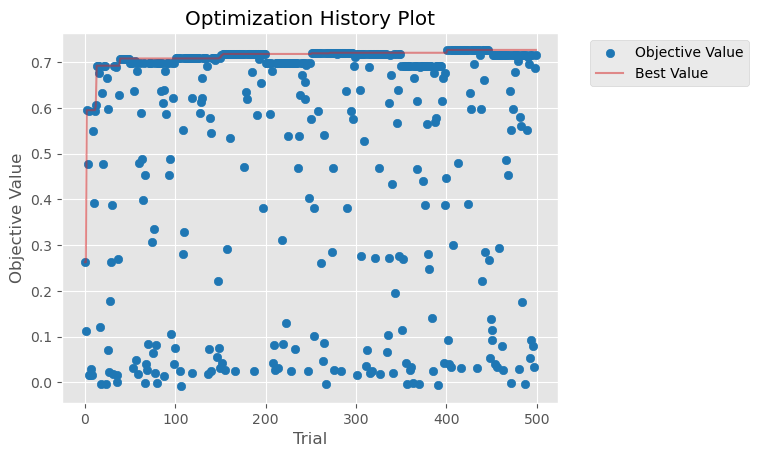

In [159]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study_svm);

In [160]:
#from optuna.visualization.matplotlib import plot_param_importances

#plot_param_importances(study_svm);

In [161]:
detailed_objective_svm_cv(study_svm.best_trial, X, Y, Y_class)

,Metric,Value (average),Value (std)
0,R2,0.743302,0.042489
1,TP,16.400000,2.756810
2,TN,154.400000,2.118700
3,FP,3.200000,1.873796
4,FN,17.000000,3.091206
5,Accuracy,0.894241,0.019868
6,Precision,0.839048,0.083610
7,Sensitivity,0.491798,0.086992
8,Specificity,0.979700,0.011860
9,F1 score,0.616641,0.082395


In [162]:
mat_met_svm_test['ave'] = mat_met_svm_test.iloc[:,1:11].mean(axis='columns', numeric_only=True)
mat_met_svm_test['std'] = mat_met_svm_test.iloc[:,1:11].std(axis='columns', numeric_only=True)
mat_met_svm_test

,Metric,Set0,Set1,Set2,Set3,Set4,Set5,Set6,Set7,Set8,Set9,ave,std
0,R2,0.709863,0.750816,0.745380,0.730434,0.799827,0.742039,0.758361,0.792121,0.691504,0.752298,0.747264,0.032928
1,TP,33.000000,32.000000,31.000000,29.000000,37.000000,34.000000,31.000000,35.000000,33.000000,36.000000,33.100000,2.469818
2,TN,309.000000,310.000000,308.000000,308.000000,313.000000,303.000000,307.000000,310.000000,307.000000,311.000000,308.600000,2.716207
3,FP,7.000000,5.000000,6.000000,8.000000,3.000000,12.000000,9.000000,5.000000,7.000000,2.000000,6.400000,2.913570
4,FN,33.000000,35.000000,37.000000,37.000000,29.000000,33.000000,35.000000,32.000000,35.000000,33.000000,33.900000,2.424413
5,Accuracy,0.895288,0.895288,0.887435,0.882199,0.916230,0.882199,0.884817,0.903141,0.890052,0.908377,0.894503,0.011580
6,Precision,0.825000,0.864865,0.837838,0.783784,0.925000,0.739130,0.775000,0.875000,0.825000,0.947368,0.839799,0.065498
7,Sensitivity,0.500000,0.477612,0.455882,0.439394,0.560606,0.507463,0.469697,0.522388,0.485294,0.521739,0.494008,0.035899
8,Specificity,0.977800,0.984100,0.980900,0.974700,0.990500,0.961900,0.971500,0.984100,0.977700,0.993600,0.979680,0.009230
9,F1 score,0.622642,0.615385,0.590476,0.563107,0.698113,0.601770,0.584906,0.654206,0.611111,0.672897,0.621461,0.041937


In [163]:
#change to fit into these X values 

TP = np.empty(10)
FP = np.empty(10)
TN = np.empty(10)
FN = np.empty(10)

r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 
data_svm=pd.DataFrame()

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X, Y_class)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = SVR(C = study_svm.best_params['C'], 
                        gamma=study_svm.best_params["gamma"],
                        )


        #learn
        
        optimizedCV_svm.fit(X_train,y_train)
                          
                  
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2) | (y_test<=-2)), 1, 0) 
        y_pred_optimized_svm_cat = np.where(((y_pred_optimized_svm >= 2) | (y_pred_optimized_svm <= -2)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
        
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_run0.sort_values(by='y_test_idx0', inplace=True)
svm_run0.reset_index(inplace=True, drop=True)
svm_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_run1.sort_values(by='y_test_idx1', inplace=True)
svm_run1.reset_index(inplace=True, drop=True)
svm_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_run2.sort_values(by='y_test_idx2', inplace=True)
svm_run2.reset_index(inplace=True, drop=True)
svm_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_run3.sort_values(by='y_test_idx3', inplace=True)
svm_run3.reset_index(inplace=True, drop=True)
svm_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_run4.sort_values(by='y_test_idx4', inplace=True)
svm_run4.reset_index(inplace=True, drop=True)
chembl_id = df['molecule_chembl_id']
svm_5preds = pd.concat([chembl_id,svm_run0, svm_run1, svm_run2, svm_run3, svm_run4], axis=1)
svm_5preds = svm_5preds[['molecule_chembl_id','y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds['y_pred_svm_ave'] = svm_5preds.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds['y_pred_svm_std'] = svm_5preds.iloc[:,2:].std(axis='columns', numeric_only=True)

mat_met_optimized_svm

,Metric,Value (average),Value (std)
0,R2,0.737969,0.042929
1,Accuracy,0.895707,0.016786
2,Precision,0.837089,0.066949
3,Sensitivity,0.503539,0.089100
4,Specificity,0.978802,0.010659
5,F1 score,0.624209,0.077589
6,F1 score (weighted),0.884279,0.021087
7,F1 score (macro),0.781799,0.043168
8,Balanced Accuracy,0.741168,0.043995
9,MCC,0.595718,0.075089


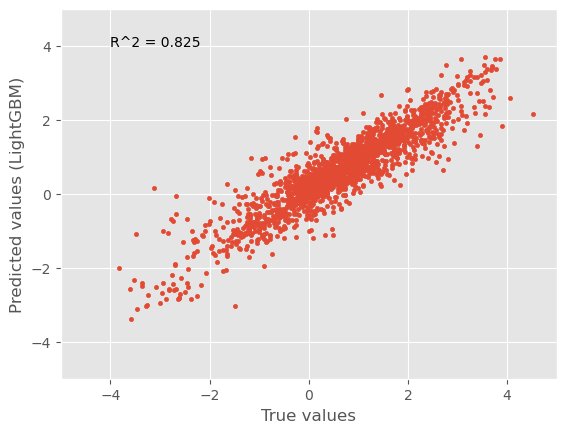

In [164]:
# Scatter plot

limits = -5,5
plt.figsize=(10,10)

plt.scatter(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'], marker=".")
lin = np.linspace(*limits, 100)

plt.ylabel("Predicted values (LightGBM)")
plt.xlabel("True values")

plt.xlim(limits)
plt.ylim(limits)

plt.annotate("R^2 = {:.3f}".format(r2_score(svm_5preds['y_test0'], svm_5preds['y_pred_svm_ave'])), (-4, 4))
plt.show()

In [165]:
#cross valide using this optimized SVR 
svm_baseline_CVscore = cross_val_score(svm_reg, X, Y, cv=10, scoring="r2")
#cv_svm_opt_testSet = cross_val_score(optimized_svm, X, Y, cv=10, scoring="r2")
cv_svm_opt = cross_val_score(optimizedCV_svm, X, Y, cv=10, scoring="r2")
print("SVM baseline model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(svm_baseline_CVscore), np.std(svm_baseline_CVscore, ddof=1)))
#print("SVM optimized model (tested on Y_te) r2_score %0.4f with a standard deviation of %0.4f" % (svm_baseline_CVscore.mean(), svm_baseline_CVscore.std()))
print("SVM optimized model r2_score %0.4f with a standard deviation of %0.4f" % (np.mean(cv_svm_opt), np.std(cv_svm_opt, ddof=1)))

SVM baseline model r2_score 0.7105 with a standard deviation of 0.0516
SVM optimized model r2_score 0.7445 with a standard deviation of 0.0468


In [166]:
joblib.dump(svm_reg, "OUTPUT/svm_reg_withSemiSel.joblib")
joblib.dump(optimizedCV_svm, "OUTPUT/optimizedCV_svm_withSemiSel.joblib")

['OUTPUT/optimizedCV_svm_withSemiSel.joblib']

In [167]:
# save the evaluation results of test set 

with pd.ExcelWriter("OUTPUT/TestSet_EvaluationResults_withSemiSel.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_rf_test.to_excel(writer, sheet_name="RF", )
    mat_met_lgbm_test.to_excel(writer, sheet_name="LGBM", )
    mat_met_xgb_test.to_excel(writer, sheet_name="XGB", )
    mat_met_knn_test.to_excel(writer, sheet_name="KNN", )
    mat_met_svm_test.to_excel(writer, sheet_name="SVM", )
   

In [168]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/EvaluationResults_withSemiSel.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_optimized_rf.to_excel(writer, sheet_name="RF", )
    mat_met_optimized_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_optimized_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_optimized_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_optimized_svm.to_excel(writer, sheet_name="SVM", )

In [169]:
# save the evaluation results of Optimized and saved models to an Excel file

with pd.ExcelWriter("OUTPUT/PredResults_withSemiSel.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    rf_5preds.to_excel(writer, sheet_name="RF", )
    lgbm_5preds.to_excel(writer, sheet_name="LGBM", )
    xgb_5preds.to_excel(writer, sheet_name="XGB", )
    knn_5preds.to_excel(writer, sheet_name="KNN", )
    svm_5preds.to_excel(writer, sheet_name="SVM", )